## 1. Import Libraries & Load Data

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [43]:

# Load data
train = pd.read_csv(r'D:\Topic_13_Project\Topic_13_Retail_Store_Sales_Time_Series\data\processed\train_cleaned.csv', parse_dates=['date'])
stores = pd.read_csv(r'D:\Topic_13_Project\Topic_13_Retail_Store_Sales_Time_Series\data\processed\stores_cleaned.csv')
print(f"Data shape: {train.shape}")
print(f"Date range: {train['date'].min()} to {train['date'].max()}")
print(f"Stores shape: {stores.shape}")

Data shape: (3000888, 6)
Date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Stores shape: (54, 6)


## 2. Data Preparation

In [44]:
# ==== DATA QUALITY CHECK ====
print("=== TRAIN DATA ===")
print(train.dtypes)
print(f"\nMissing values:\n{train.isnull().sum()}")
print(f"\nZero sales records: {(train['sales'] == 0).sum():,} ({(train['sales'] == 0).mean()*100:.2f}%)")

print("\n=== STORES DATA ===")
print(stores.dtypes)
print(f"\nMissing values:\n{stores.isnull().sum()}")
print(f"\nStore types: {sorted(stores['type'].unique())}")
print(f"Clusters: {sorted(stores['cluster'].unique())}")
print(f"Cities: {stores['city'].nunique()} unique")
print(f"States: {stores['state'].nunique()} unique")

=== TRAIN DATA ===
id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

Missing values:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Zero sales records: 939,130 (31.30%)

=== STORES DATA ===
store_nbr        int64
city            object
state           object
type            object
cluster          int64
type_encoded     int64
dtype: object

Missing values:
store_nbr       0
city            0
state           0
type            0
cluster         0
type_encoded    0
dtype: int64

Store types: ['A', 'B', 'C', 'D', 'E']
Clusters: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17)]
Cities: 22 unique
States: 

In [45]:
# ==== MERGE TRAIN + STORES ====
df = train.merge(stores, on='store_nbr', how='left')
print(f"Merged shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Merged shape: (3000888, 11)
Columns: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state', 'type', 'cluster', 'type_encoded']


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,type_encoded
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,3
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,3
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,3
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,3
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,3


In [46]:
# ==== AGGREGATE SALES BY STORE ====
store_metrics = df.groupby('store_nbr').agg(
    total_sales=('sales', 'sum'),
    avg_daily_sales=('sales', 'mean'),
    median_daily_sales=('sales', 'median'),
    std_daily_sales=('sales', 'std'),
    max_daily_sales=('sales', 'max'),
    zero_sales_count=('sales', lambda x: (x == 0).sum()),
    total_records=('sales', 'count')
).reset_index()

# Calculate derived metrics
store_metrics['cv'] = store_metrics['std_daily_sales'] / store_metrics['avg_daily_sales']  # Coefficient of Variation
store_metrics['zero_sales_pct'] = store_metrics['zero_sales_count'] / store_metrics['total_records'] * 100

# Merge with store metadata
store_metrics = store_metrics.merge(stores, on='store_nbr', how='left')

# Rank stores
store_metrics['rank_total'] = store_metrics['total_sales'].rank(ascending=False).astype(int)
store_metrics = store_metrics.sort_values('total_sales', ascending=False)

print(f"Store metrics calculated for {len(store_metrics)} stores")
print(f"\nTop 5 stores by total sales:")
print(store_metrics[['store_nbr', 'city', 'state', 'type', 'cluster', 'total_sales', 'avg_daily_sales', 'cv', 'zero_sales_pct']].head())
print(f"\nBottom 5 stores by total sales:")
print(store_metrics[['store_nbr', 'city', 'state', 'type', 'cluster', 'total_sales', 'avg_daily_sales', 'cv', 'zero_sales_pct']].tail())

Store metrics calculated for 54 stores

Top 5 stores by total sales:
    store_nbr   city      state type  cluster   total_sales  avg_daily_sales  \
43         44  Quito  Pichincha    A        5  6.208755e+07      1117.245254   
44         45  Quito  Pichincha    A       11  5.449801e+07       980.673908   
46         47  Quito  Pichincha    A       14  5.094831e+07       916.798209   
2           3  Quito  Pichincha    D        8  5.048191e+07       908.405495   
48         49  Quito  Pichincha    A       11  4.342010e+07       781.330450   

          cv  zero_sales_pct  
43  2.403485       17.947887  
44  2.431309       19.358670  
46  2.423998       18.953790  
2   2.362585       18.140430  
48  2.429013       19.347873  

Bottom 5 stores by total sales:
    store_nbr       city    state type  cluster   total_sales  \
34         35     Playas   Guayas    C        3  7.676679e+06   
29         30  Guayaquil   Guayas    C        3  7.382074e+06   
31         32  Guayaquil   Guayas   

In [47]:
# ==== SUMMARY STATISTICS ====
print("="*70)
print("STORE PERFORMANCE OVERVIEW")
print("="*70)

print(f"\nTotal stores: {len(store_metrics)}")
print(f"Total sales (all stores): ${store_metrics['total_sales'].sum():,.0f}")
print(f"Average total sales per store: ${store_metrics['total_sales'].mean():,.0f}")
print(f"Median total sales per store: ${store_metrics['total_sales'].median():,.0f}")

# Concentration
top5_share = store_metrics.head(5)['total_sales'].sum() / store_metrics['total_sales'].sum() * 100
top10_share = store_metrics.head(10)['total_sales'].sum() / store_metrics['total_sales'].sum() * 100
bottom10_share = store_metrics.tail(10)['total_sales'].sum() / store_metrics['total_sales'].sum() * 100

print(f"\nConcentration:")
print(f"  Top 5 stores: {top5_share:.1f}% of total sales")
print(f"  Top 10 stores: {top10_share:.1f}% of total sales")
print(f"  Bottom 10 stores: {bottom10_share:.1f}% of total sales")
print(f"  Max/Min ratio: {store_metrics['total_sales'].max() / store_metrics['total_sales'].min():.1f}x")

print(f"\nZero Sales Analysis:")
print(f"  Average zero-sales %: {store_metrics['zero_sales_pct'].mean():.1f}%")
print(f"  Max zero-sales %: {store_metrics['zero_sales_pct'].max():.1f}% (Store {store_metrics.loc[store_metrics['zero_sales_pct'].idxmax(), 'store_nbr']})")
print(f"  Min zero-sales %: {store_metrics['zero_sales_pct'].min():.1f}% (Store {store_metrics.loc[store_metrics['zero_sales_pct'].idxmin(), 'store_nbr']})")

STORE PERFORMANCE OVERVIEW

Total stores: 54
Total sales (all stores): $1,073,644,952
Average total sales per store: $19,882,314
Median total sales per store: $15,992,048

Concentration:
  Top 5 stores: 24.4% of total sales
  Top 10 stores: 40.2% of total sales
  Bottom 10 stores: 6.8% of total sales
  Max/Min ratio: 23.0x

Zero Sales Analysis:
  Average zero-sales %: 31.3%
  Max zero-sales %: 93.5% (Store 52)
  Min zero-sales %: 17.9% (Store 44)


## 3. Top 10 & Bottom 10 Stores by Total Sales

Nhận diện stores có performance cao nhất và thấp nhất.

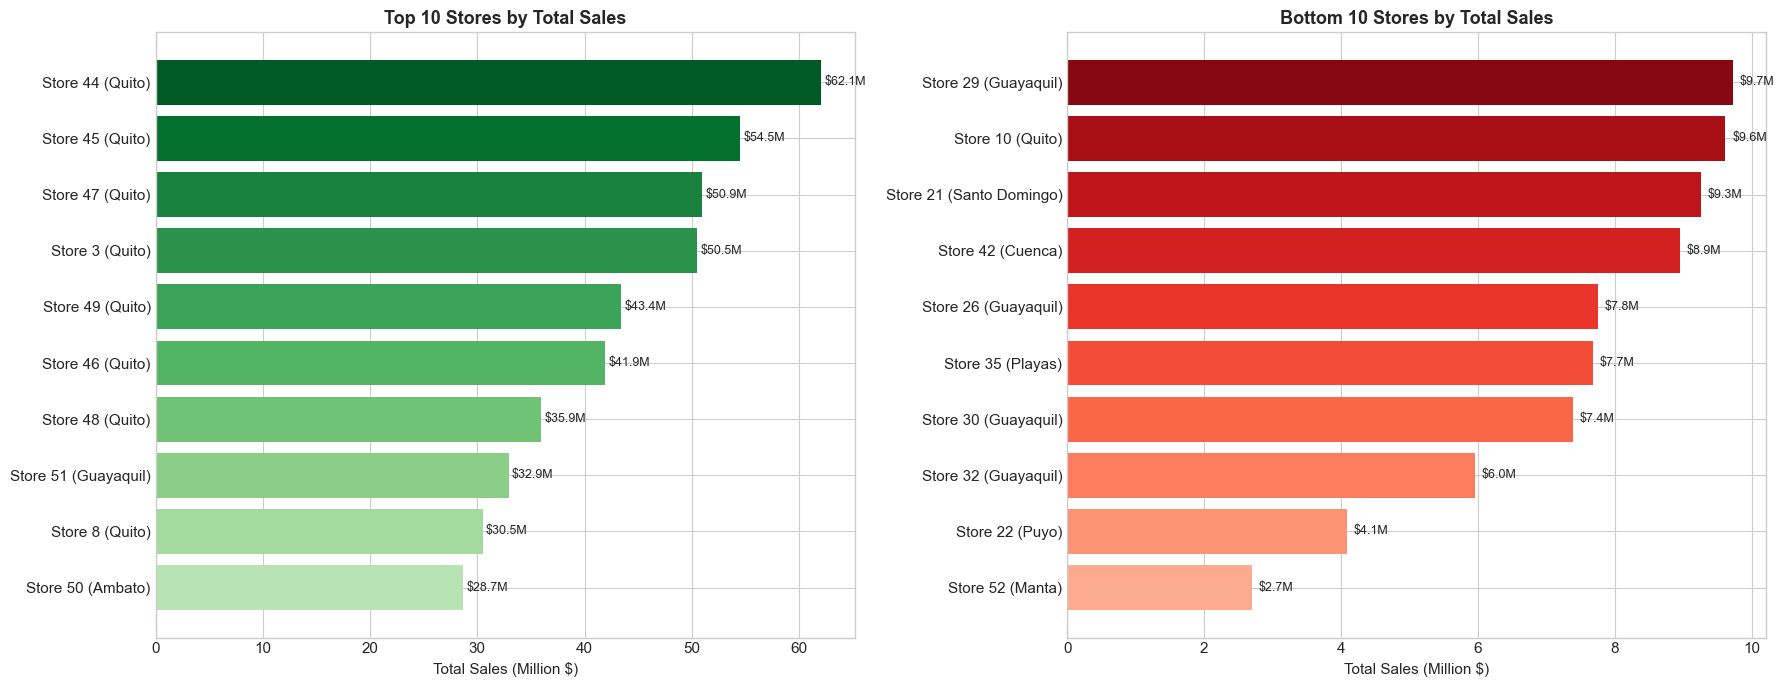


=== KEY INSIGHT ===
Best: Store 44 (Quito, Pichincha) - Type A, Cluster 5
Worst: Store 52 (Manta, Manabi) - Type A, Cluster 11
Difference: 23.0x


In [48]:
# ==== BAR CHART: TOP 10 & BOTTOM 10 STORES ====
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Top 10
top10 = store_metrics.head(10).sort_values('total_sales', ascending=True)
colors_top = [plt.cm.Greens(0.3 + 0.07 * i) for i in range(10)]
bars1 = axes[0].barh(
    [f"Store {int(s)} ({c})" for s, c in zip(top10['store_nbr'], top10['city'])],
    top10['total_sales'] / 1e6,
    color=colors_top
)
axes[0].set_xlabel('Total Sales (Million $)')
axes[0].set_title('Top 10 Stores by Total Sales', fontweight='bold')
for bar, val in zip(bars1, top10['total_sales'] / 1e6):
    axes[0].text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
                 f'${val:.1f}M', va='center', fontsize=9)

# Bottom 10
bottom10 = store_metrics.tail(10).sort_values('total_sales', ascending=True)
colors_bot = [plt.cm.Reds(0.3 + 0.07 * i) for i in range(10)]
bars2 = axes[1].barh(
    [f"Store {int(s)} ({c})" for s, c in zip(bottom10['store_nbr'], bottom10['city'])],
    bottom10['total_sales'] / 1e6,
    color=colors_bot
)
axes[1].set_xlabel('Total Sales (Million $)')
axes[1].set_title('Bottom 10 Stores by Total Sales', fontweight='bold')
for bar, val in zip(bars2, bottom10['total_sales'] / 1e6):
    axes[1].text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                 f'${val:.1f}M', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print comparison
print("\n=== KEY INSIGHT ===")
best = store_metrics.iloc[0]
worst = store_metrics.iloc[-1]
print(f"Best: Store {int(best['store_nbr'])} ({best['city']}, {best['state']}) - Type {best['type']}, Cluster {int(best['cluster'])}")
print(f"Worst: Store {int(worst['store_nbr'])} ({worst['city']}, {worst['state']}) - Type {worst['type']}, Cluster {int(worst['cluster'])}")
print(f"Difference: {best['total_sales']/worst['total_sales']:.1f}x")

## 4. Sales Distribution by Store Type (A, B, C, D, E)

Phân tích xem store type nào có sales cao nhất và có significant difference giữa các types không.

In [49]:
# ==== STORE TYPE ANALYSIS ====
# Count stores per type
type_counts = stores['type'].value_counts().sort_index()
print("Store count by type:")
print(type_counts)

# Type-level metrics
type_metrics = store_metrics.groupby('type').agg(
    num_stores=('store_nbr', 'count'),
    total_sales=('total_sales', 'sum'),
    avg_total_sales=('total_sales', 'mean'),
    median_total_sales=('total_sales', 'median'),
    avg_daily=('avg_daily_sales', 'mean'),
    avg_cv=('cv', 'mean'),
    avg_zero_pct=('zero_sales_pct', 'mean')
).round(2)

print("\nType-level metrics:")
print(type_metrics)

Store count by type:
type
A     9
B     8
C    15
D    18
E     4
Name: count, dtype: int64

Type-level metrics:
      num_stores   total_sales  avg_total_sales  median_total_sales  \
type                                                                  
A              9  3.530438e+08      39227093.53         41896062.12   
B              8  1.452606e+08      18157579.39         17418803.43   
C             15  1.644347e+08      10962316.17         10986412.55   
D             18  3.510833e+08      19504627.60         18884849.82   
E              4  5.982244e+07      14955608.96         15857061.65   

      avg_daily  avg_cv  avg_zero_pct  
type                                   
A        705.88    3.20         27.84  
B        326.74    2.99         33.30  
C        197.26    2.90         35.96  
D        350.98    2.54         26.68  
E        269.12    2.87         38.34  


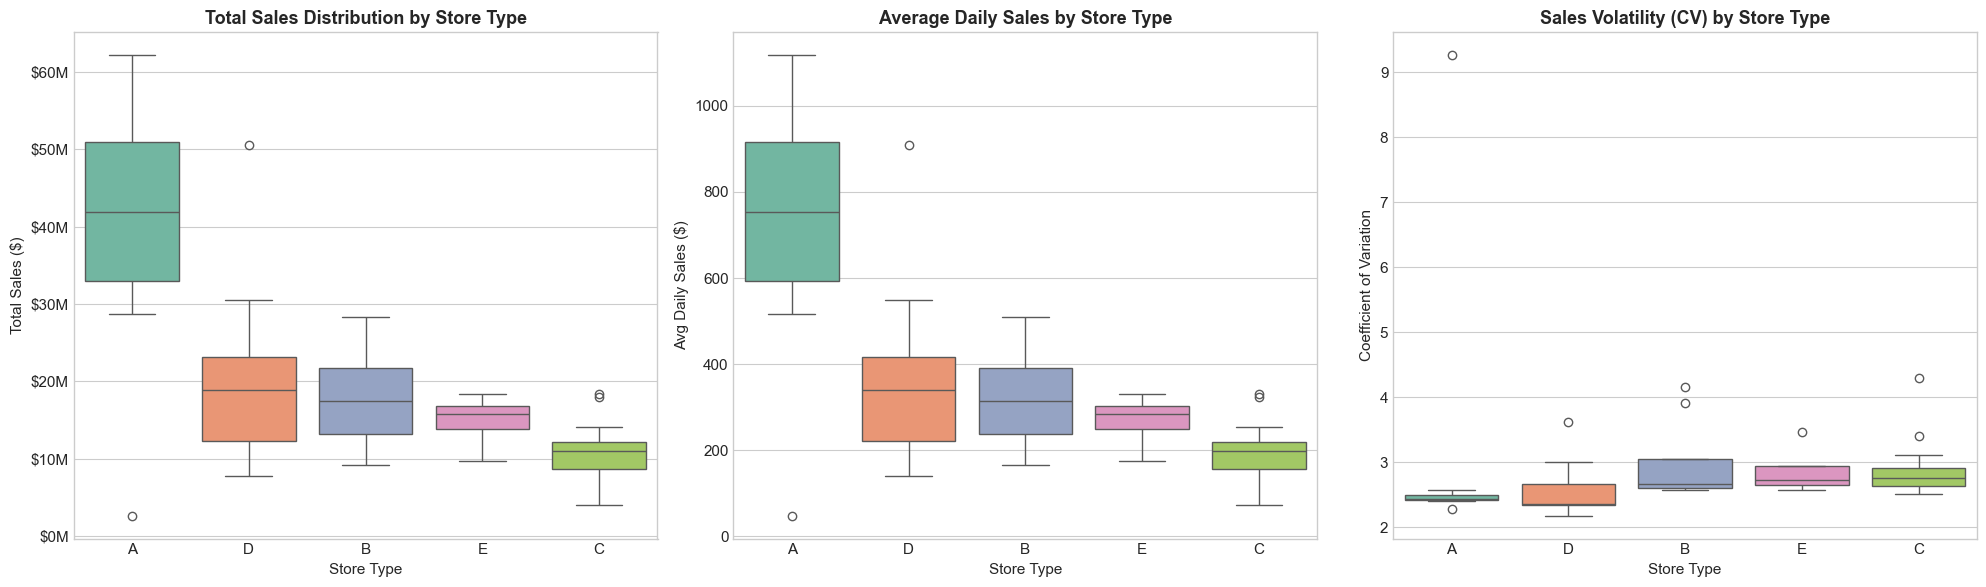

In [50]:
# ==== BOX PLOTS: SALES BY STORE TYPE ====
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# (A) Box plot: Total sales by type
type_order = store_metrics.groupby('type')['total_sales'].median().sort_values(ascending=False).index
sns.boxplot(data=store_metrics, x='type', y='total_sales', order=type_order, ax=axes[0], palette='Set2')
axes[0].set_title('Total Sales Distribution by Store Type', fontweight='bold')
axes[0].set_ylabel('Total Sales ($)')
axes[0].set_xlabel('Store Type')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.0f}M'))

# (B) Box plot: Average daily sales by type
sns.boxplot(data=store_metrics, x='type', y='avg_daily_sales', order=type_order, ax=axes[1], palette='Set2')
axes[1].set_title('Average Daily Sales by Store Type', fontweight='bold')
axes[1].set_ylabel('Avg Daily Sales ($)')
axes[1].set_xlabel('Store Type')

# (C) Box plot: CV (stability) by type
sns.boxplot(data=store_metrics, x='type', y='cv', order=type_order, ax=axes[2], palette='Set2')
axes[2].set_title('Sales Volatility (CV) by Store Type', fontweight='bold')
axes[2].set_ylabel('Coefficient of Variation')
axes[2].set_xlabel('Store Type')

plt.tight_layout()
plt.show()

In [51]:
# ==== STATISTICAL TEST: Kruskal-Wallis (Non-parametric ANOVA) ====
# Test if there's significant difference between store types
groups = [group['total_sales'].values for name, group in store_metrics.groupby('type')]
h_stat, p_value = stats.kruskal(*groups)

print("=== Kruskal-Wallis Test: Sales ~ Store Type ===")
print(f"H-statistic: {h_stat:.4f}")
print(f"P-value: {p_value:.6f}")
if p_value < 0.05:
    print("=> SIGNIFICANT difference between store types (p < 0.05)")
else:
    print("=> NO significant difference between store types (p >= 0.05)")

# Pairwise comparisons (Mann-Whitney U)
print("\n=== Pairwise Mann-Whitney U Tests ===")
types = sorted(store_metrics['type'].unique())
for i in range(len(types)):
    for j in range(i+1, len(types)):
        g1 = store_metrics[store_metrics['type'] == types[i]]['total_sales']
        g2 = store_metrics[store_metrics['type'] == types[j]]['total_sales']
        u_stat, p_val = stats.mannwhitneyu(g1, g2, alternative='two-sided')
        sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
        print(f"  {types[i]} vs {types[j]}: U={u_stat:.0f}, p={p_val:.4f} {sig}")

=== Kruskal-Wallis Test: Sales ~ Store Type ===
H-statistic: 21.4630
P-value: 0.000256
=> SIGNIFICANT difference between store types (p < 0.05)

=== Pairwise Mann-Whitney U Tests ===
  A vs B: U=64, p=0.0055 **
  A vs C: U=120, p=0.0019 **
  A vs D: U=138, p=0.0037 **
  A vs E: U=32, p=0.0336 *
  B vs C: U=98, p=0.0130 *
  B vs D: U=71, p=0.9783 ns
  B vs E: U=20, p=0.5697 ns
  C vs D: U=44, p=0.0011 **
  C vs E: U=15, p=0.1522 ns
  D vs E: U=47, p=0.3863 ns


## 5. Sales Distribution by Cluster (1-17)

Clusters thường nhóm các stores có đặc tính tương tự. Phân tích xem clusters có ý nghĩa gì về mặt sales.

In [52]:
# ==== CLUSTER ANALYSIS ====
cluster_metrics = store_metrics.groupby('cluster').agg(
    num_stores=('store_nbr', 'count'),
    avg_total_sales=('total_sales', 'mean'),
    median_total_sales=('total_sales', 'median'),
    avg_daily=('avg_daily_sales', 'mean'),
    avg_cv=('cv', 'mean'),
    avg_zero_pct=('zero_sales_pct', 'mean'),
    types=('type', lambda x: ', '.join(sorted(x.unique())))
).round(2)

cluster_metrics = cluster_metrics.sort_values('avg_total_sales', ascending=False)
print("Cluster metrics (sorted by avg total sales):")
print(cluster_metrics.to_string())

Cluster metrics (sorted by avg total sales):
         num_stores  avg_total_sales  median_total_sales  avg_daily  avg_cv  avg_zero_pct    types
cluster                                                                                           
5                 1      62087553.25         62087553.25    1117.25    2.40         17.95        A
14                4      39357630.77         38914596.20     708.23    2.50         20.06        A
8                 3      35976082.23         30494286.93     647.38    2.35         19.63        D
11                3      33538091.98         43420095.78     603.51    4.71         44.08        A
17                1      32911489.54         32911489.54     592.23    2.28         20.12        A
6                 6      19042397.79         18671463.35     342.66    3.13         34.74        B
1                 3      18125583.99         19188021.38     326.16    2.49         26.03        D
12                1      18030969.25         18030969.25     324

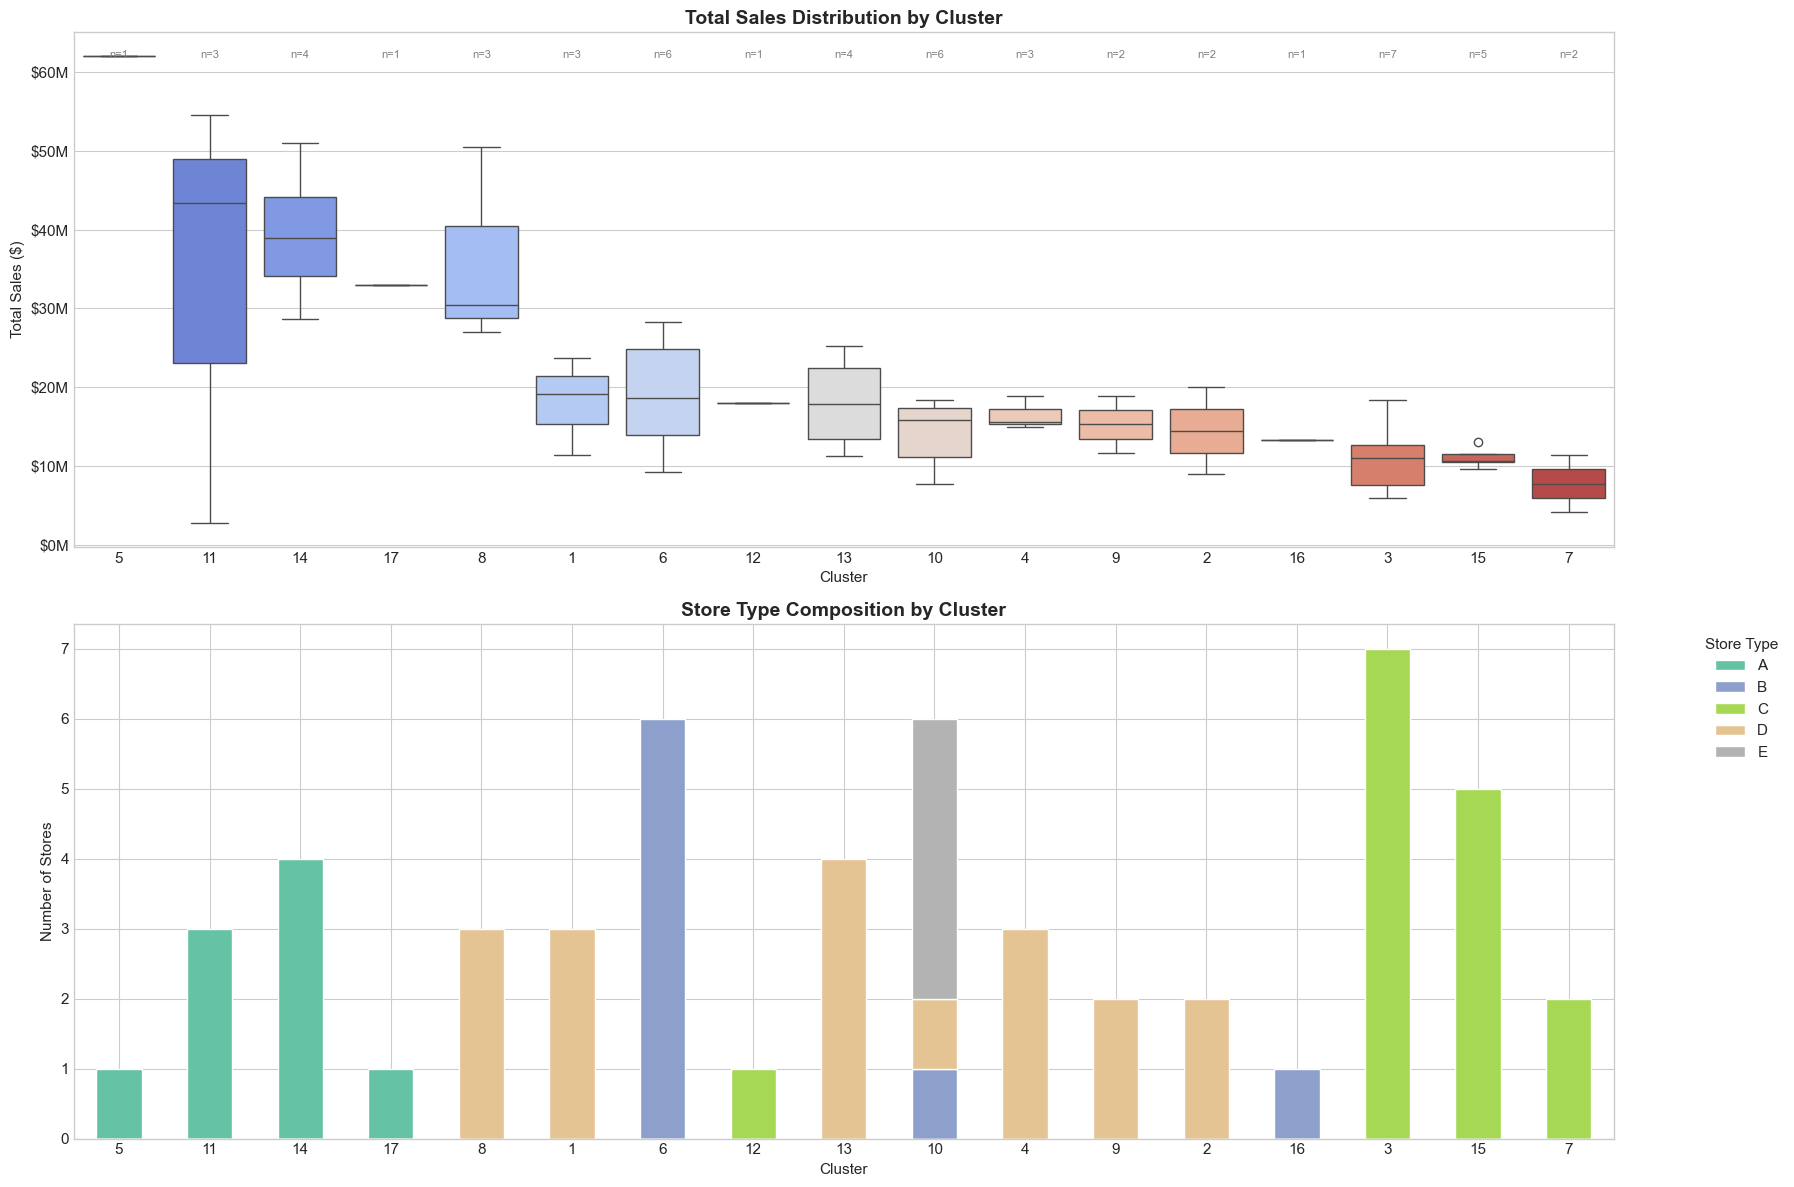

In [53]:
# ==== BOX PLOTS: SALES BY CLUSTER ====
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# (A) Box plot: Total sales by cluster
cluster_order = store_metrics.groupby('cluster')['total_sales'].median().sort_values(ascending=False).index
sns.boxplot(data=store_metrics, x='cluster', y='total_sales', order=cluster_order, ax=axes[0], palette='coolwarm')
axes[0].set_title('Total Sales Distribution by Cluster', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Total Sales ($)')
axes[0].set_xlabel('Cluster')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.0f}M'))

# Add store counts
for i, cl in enumerate(cluster_order):
    n = (store_metrics['cluster'] == cl).sum()
    axes[0].text(i, axes[0].get_ylim()[1] * 0.95, f'n={n}', ha='center', fontsize=8, color='gray')

# (B) Bar plot: Average daily sales by cluster with type composition
cluster_type_counts = store_metrics.groupby(['cluster', 'type']).size().unstack(fill_value=0)
cluster_type_counts = cluster_type_counts.reindex(cluster_order)

cluster_type_counts.plot(kind='bar', stacked=True, ax=axes[1], colormap='Set2', edgecolor='white')
axes[1].set_title('Store Type Composition by Cluster', fontweight='bold', fontsize=14)
axes[1].set_ylabel('Number of Stores')
axes[1].set_xlabel('Cluster')
axes[1].legend(title='Store Type', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

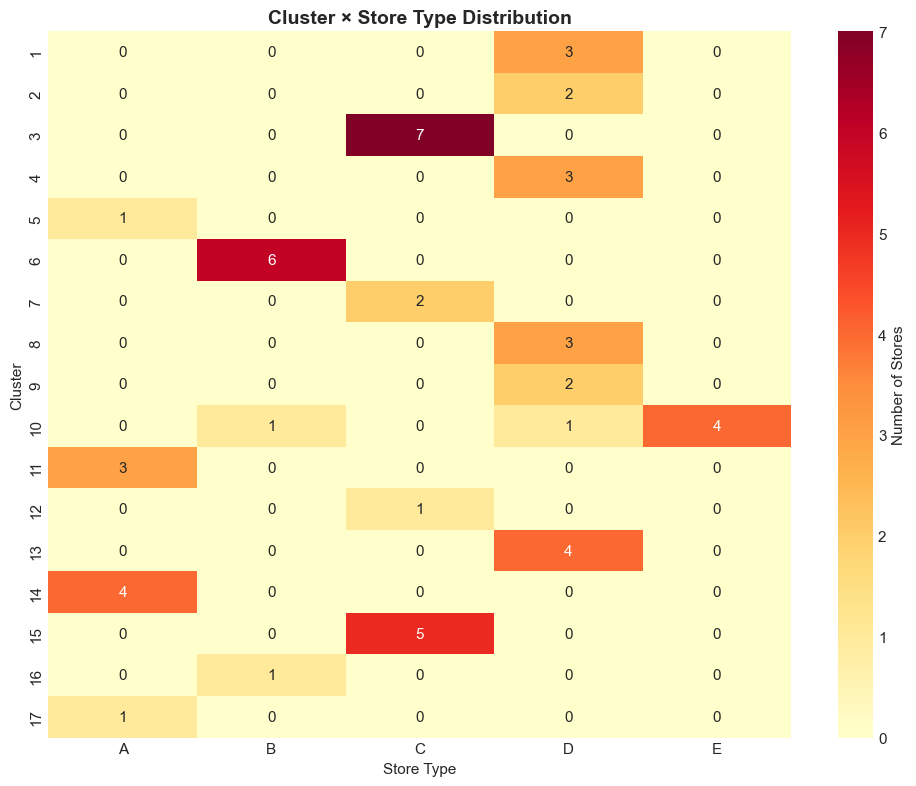


=== Kruskal-Wallis Test: Sales ~ Cluster ===
H-statistic: 29.8442
P-value: 0.018827
=> SIGNIFICANT difference between clusters (p < 0.05)


In [54]:
# ==== CLUSTER HEATMAP: Cluster × Type CrossTab ====
ct = pd.crosstab(store_metrics['cluster'], store_metrics['type'])
plt.figure(figsize=(10, 8))
sns.heatmap(ct, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Number of Stores'})
plt.title('Cluster × Store Type Distribution', fontweight='bold', fontsize=14)
plt.xlabel('Store Type')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

print("\n=== Kruskal-Wallis Test: Sales ~ Cluster ===")
groups_cl = [group['total_sales'].values for name, group in store_metrics.groupby('cluster')]
h_stat_cl, p_value_cl = stats.kruskal(*groups_cl)
print(f"H-statistic: {h_stat_cl:.4f}")
print(f"P-value: {p_value_cl:.6f}")
if p_value_cl < 0.05:
    print("=> SIGNIFICANT difference between clusters (p < 0.05)")
else:
    print("=> NO significant difference between clusters (p >= 0.05)")

## 6. Geographic Analysis: City & State

Phân tích geographic patterns - Quito vs Guayaquil, coastal vs highland regions.

In [55]:
# ==== CITY ANALYSIS ====
city_metrics = store_metrics.groupby('city').agg(
    num_stores=('store_nbr', 'count'),
    total_sales=('total_sales', 'sum'),
    avg_total_sales=('total_sales', 'mean'),
    avg_daily=('avg_daily_sales', 'mean'),
    avg_cv=('cv', 'mean'),
    states=('state', 'first')
).reset_index()
city_metrics = city_metrics.sort_values('avg_total_sales', ascending=False)

print("City metrics:")
print(city_metrics.to_string(index=False))

City metrics:
         city  num_stores  total_sales  avg_total_sales  avg_daily   avg_cv                         states
        Quito          18 5.567418e+08     3.093010e+07 556.577090 2.581263                      Pichincha
      Cayambe           1 2.832556e+07     2.832556e+07 509.709179 2.668694                      Pichincha
       Ambato           2 4.030440e+07     2.015220e+07 362.632273 2.332973                     Tungurahua
        Daule           1 1.918802e+07     1.918802e+07 345.282181 2.359312                         Guayas
         Loja           1 1.886000e+07     1.886000e+07 339.379530 2.470649                           Loja
     Babahoyo           1 1.774687e+07     1.774687e+07 319.349181 2.613288                       Los Rios
      Machala           2 3.338680e+07     1.669340e+07 300.392253 2.636529                         El Oro
   Esmeraldas           1 1.639169e+07     1.639169e+07 294.963151 2.761304                     Esmeraldas
       Cuenca          

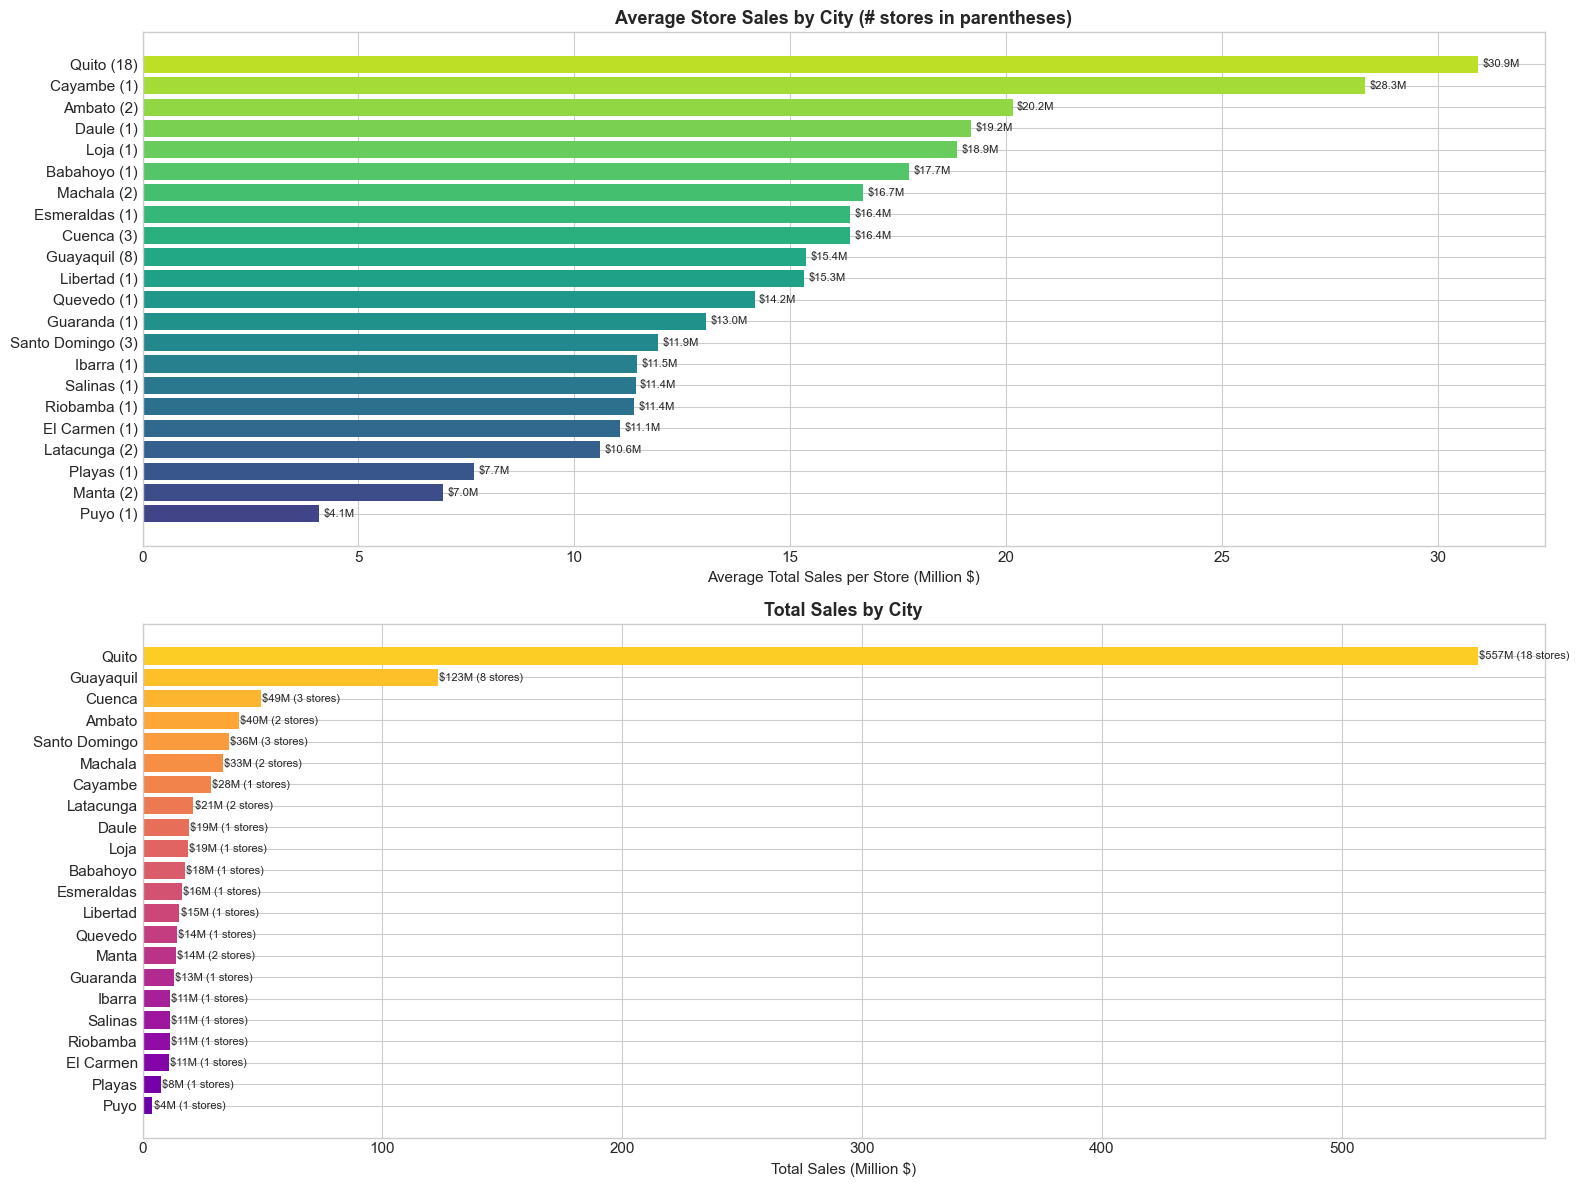

In [56]:
# ==== BAR CHART: AVERAGE SALES BY CITY ====
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# (A) Average total sales per store by city
city_sorted = city_metrics.sort_values('avg_total_sales', ascending=True)
colors_city = plt.cm.viridis(np.linspace(0.2, 0.9, len(city_sorted)))
bars = axes[0].barh(
    [f"{c} ({n})" for c, n in zip(city_sorted['city'], city_sorted['num_stores'])],
    city_sorted['avg_total_sales'] / 1e6,
    color=colors_city
)
axes[0].set_xlabel('Average Total Sales per Store (Million $)')
axes[0].set_title('Average Store Sales by City (# stores in parentheses)', fontweight='bold', fontsize=13)
for bar, val in zip(bars, city_sorted['avg_total_sales'] / 1e6):
    axes[0].text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                 f'${val:.1f}M', va='center', fontsize=8)

# (B) Total sales contribution by city (stacked or grouped)
city_total = city_metrics.sort_values('total_sales', ascending=True)
bars2 = axes[1].barh(
    city_total['city'],
    city_total['total_sales'] / 1e6,
    color=plt.cm.plasma(np.linspace(0.2, 0.9, len(city_total)))
)
axes[1].set_xlabel('Total Sales (Million $)')
axes[1].set_title('Total Sales by City', fontweight='bold', fontsize=13)
for bar, val, n in zip(bars2, city_total['total_sales'] / 1e6, city_total['num_stores']):
    axes[1].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                 f'${val:.0f}M ({n} stores)', va='center', fontsize=8)

plt.tight_layout()

plt.show()

In [57]:
# ==== STATE ANALYSIS ====
state_metrics = store_metrics.groupby('state').agg(
    num_stores=('store_nbr', 'count'),
    total_sales=('total_sales', 'sum'),
    avg_total_sales=('total_sales', 'mean'),
    avg_daily=('avg_daily_sales', 'mean'),
    avg_cv=('cv', 'mean'),
    cities=('city', lambda x: ', '.join(sorted(x.unique())))
).reset_index()
state_metrics = state_metrics.sort_values('avg_total_sales', ascending=False)

print("State metrics:")
print(state_metrics.to_string(index=False))

State metrics:
                         state  num_stores  total_sales  avg_total_sales  avg_daily   avg_cv                             cities
                     Pichincha          19 5.850674e+08     3.079302e+07 554.110358 2.585865                     Cayambe, Quito
                    Tungurahua           2 4.030440e+07     2.015220e+07 362.632273 2.332973                             Ambato
                          Loja           1 1.886000e+07     1.886000e+07 339.379530 2.470649                               Loja
                        El Oro           2 3.338680e+07     1.669340e+07 300.392253 2.636529                            Machala
                    Esmeraldas           1 1.639169e+07     1.639169e+07 294.963151 2.761304                         Esmeraldas
                         Azuay           3 4.916860e+07     1.638953e+07 294.924279 2.915062                             Cuenca
                      Los Rios           2 3.192537e+07     1.596269e+07 287.243342 2.565

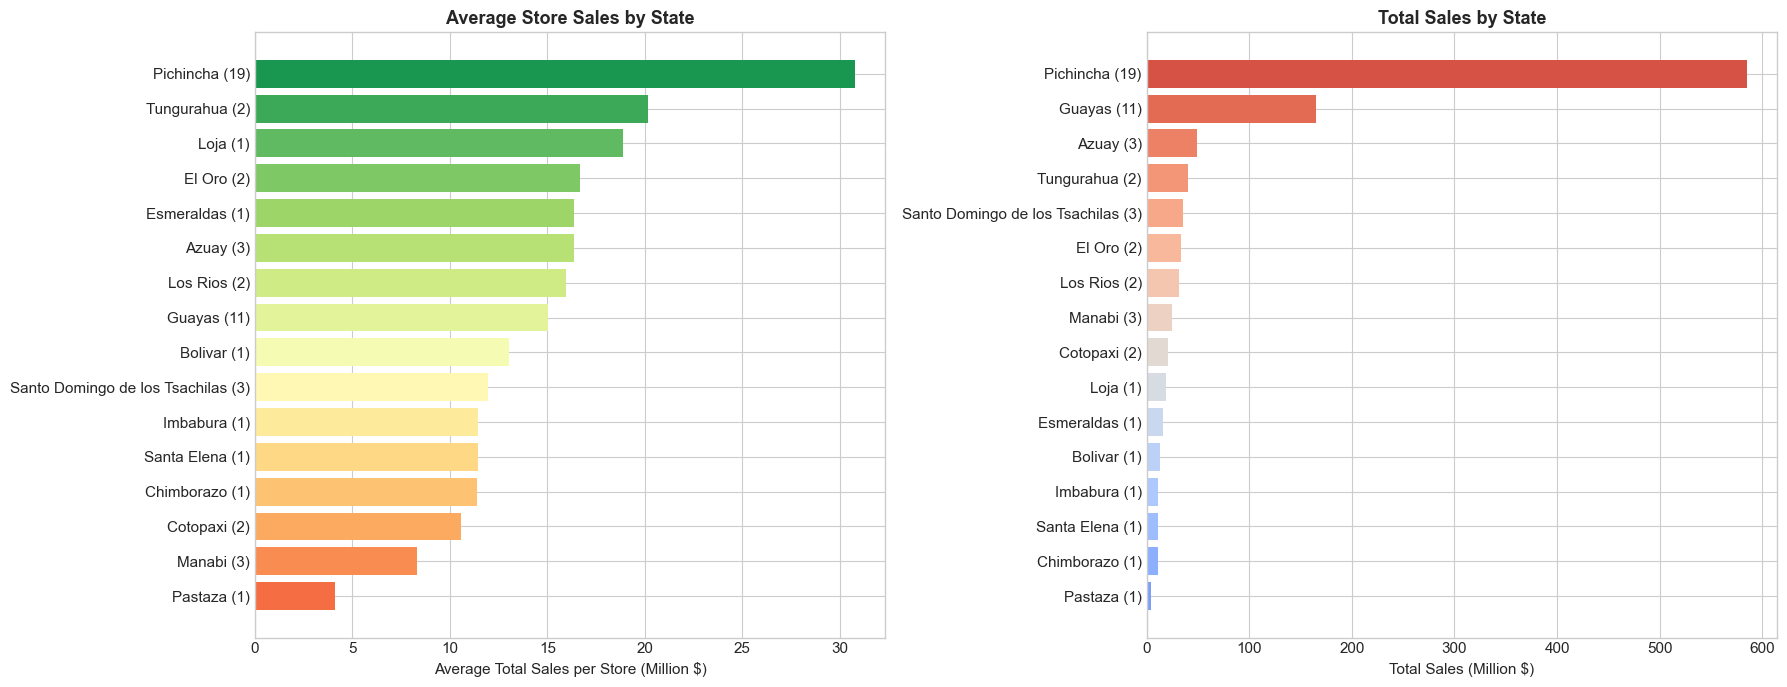


=== Quito vs Guayaquil ===

Quito:
  # Stores: 18
  Total sales: $556,741,837
  Avg sales per store: $30,930,102
  Types: {'D': np.int64(7), 'A': np.int64(6), 'B': np.int64(3), 'C': np.int64(2)}
  Clusters: [np.int64(5), np.int64(6), np.int64(8), np.int64(9), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16)]

Guayaquil:
  # Stores: 8
  Total sales: $122,967,260
  Avg sales per store: $15,370,908
  Types: {'D': np.int64(2), 'C': np.int64(2), 'E': np.int64(2), 'A': np.int64(1), 'B': np.int64(1)}
  Clusters: [np.int64(1), np.int64(3), np.int64(6), np.int64(10), np.int64(17)]


In [58]:
# ==== BAR CHART: AVERAGE SALES BY STATE ====
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# (A) Average sales per store by state
state_sorted = state_metrics.sort_values('avg_total_sales', ascending=True)
colors_s = plt.cm.RdYlGn(np.linspace(0.2, 0.9, len(state_sorted)))
bars_s = axes[0].barh(
    [f"{s} ({n})" for s, n in zip(state_sorted['state'], state_sorted['num_stores'])],
    state_sorted['avg_total_sales'] / 1e6,
    color=colors_s
)
axes[0].set_xlabel('Average Total Sales per Store (Million $)')
axes[0].set_title('Average Store Sales by State', fontweight='bold', fontsize=13)

# (B) Total sales by state
state_total = state_metrics.sort_values('total_sales', ascending=True)
axes[1].barh(
    [f"{s} ({n})" for s, n in zip(state_total['state'], state_total['num_stores'])],
    state_total['total_sales'] / 1e6,
    color=plt.cm.coolwarm(np.linspace(0.2, 0.9, len(state_total)))
)
axes[1].set_xlabel('Total Sales (Million $)')
axes[1].set_title('Total Sales by State', fontweight='bold', fontsize=13)

plt.tight_layout()

plt.show()

# Quito vs Guayaquil comparison
print("\n=== Quito vs Guayaquil ===")
for city_name in ['Quito', 'Guayaquil']:
    city_data = store_metrics[store_metrics['city'] == city_name]
    print(f"\n{city_name}:")
    print(f"  # Stores: {len(city_data)}")
    print(f"  Total sales: ${city_data['total_sales'].sum():,.0f}")
    print(f"  Avg sales per store: ${city_data['total_sales'].mean():,.0f}")
    print(f"  Types: {dict(city_data['type'].value_counts())}")
    print(f"  Clusters: {sorted(city_data['cluster'].unique())}")

=== Coastal vs Highland ===
          num_stores   total_sales  avg_total_sales  avg_daily  avg_cv
region                                                                
Coastal           20  2.832491e+08      14162453.66     254.85    3.08
Highland          33  7.863057e+08      23827444.77     428.77    2.66
Other              1  4.090202e+06       4090201.74      73.60    4.30


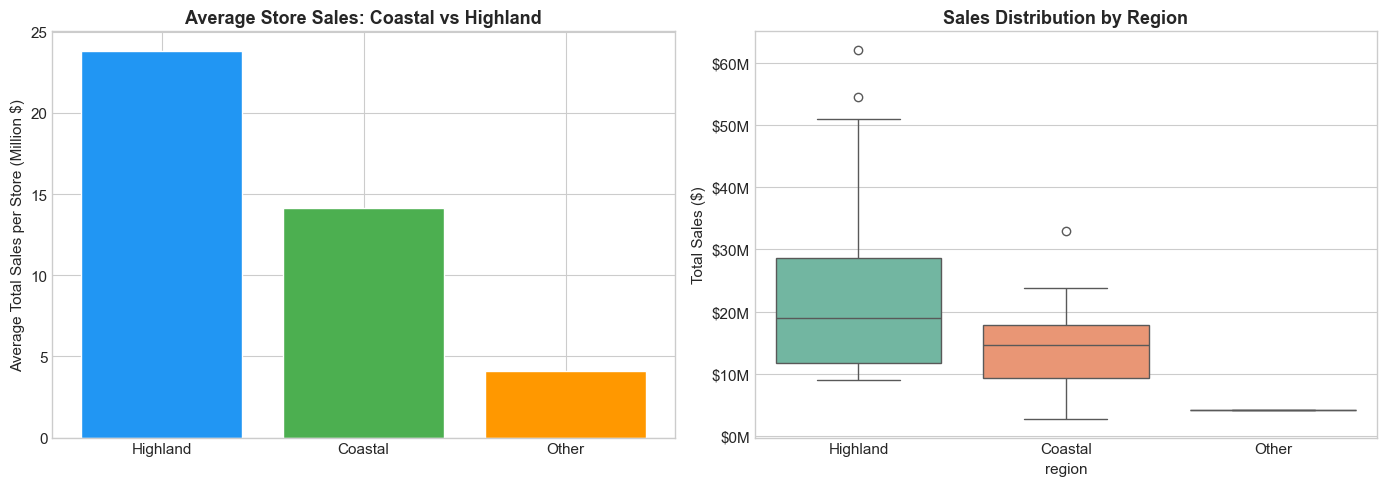


Mann-Whitney U Test (Coastal vs Highland): U=196, p=0.0143
  => SIGNIFICANT difference


In [59]:
# ==== COASTAL vs HIGHLAND ANALYSIS ====
# Ecuador geographic regions
coastal_states = ['Guayas', 'Manabi', 'El Oro', 'Los Rios', 'Esmeraldas', 'Santa Elena']
highland_states = ['Pichincha', 'Azuay', 'Tungurahua', 'Chimborazo', 'Cotopaxi',
                   'Bolivar', 'Imbabura', 'Loja', 'Santo Domingo de los Tsachilas']

store_metrics['region'] = store_metrics['state'].apply(
    lambda x: 'Coastal' if x in coastal_states else ('Highland' if x in highland_states else 'Other')
)

region_metrics = store_metrics.groupby('region').agg(
    num_stores=('store_nbr', 'count'),
    total_sales=('total_sales', 'sum'),
    avg_total_sales=('total_sales', 'mean'),
    avg_daily=('avg_daily_sales', 'mean'),
    avg_cv=('cv', 'mean')
).round(2)

print("=== Coastal vs Highland ===")
print(region_metrics)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (A) Avg total sales by region
region_sorted = region_metrics.sort_values('avg_total_sales', ascending=False)
axes[0].bar(region_sorted.index, region_sorted['avg_total_sales'] / 1e6,
            color=['#2196F3', '#4CAF50', '#FF9800'][:len(region_sorted)], edgecolor='white')
axes[0].set_ylabel('Average Total Sales per Store (Million $)')
axes[0].set_title('Average Store Sales: Coastal vs Highland', fontweight='bold')

# (B) Box plot comparison
sns.boxplot(data=store_metrics, x='region', y='total_sales', ax=axes[1], palette='Set2')
axes[1].set_ylabel('Total Sales ($)')
axes[1].set_title('Sales Distribution by Region', fontweight='bold')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.0f}M'))

plt.tight_layout()

plt.show()

# Statistical test
coastal_sales = store_metrics[store_metrics['region'] == 'Coastal']['total_sales']
highland_sales = store_metrics[store_metrics['region'] == 'Highland']['total_sales']
if len(coastal_sales) > 0 and len(highland_sales) > 0:
    u_stat, p_val = stats.mannwhitneyu(coastal_sales, highland_sales, alternative='two-sided')
    print(f"\nMann-Whitney U Test (Coastal vs Highland): U={u_stat:.0f}, p={p_val:.4f}")
    print(f"  => {'SIGNIFICANT' if p_val < 0.05 else 'NOT significant'} difference")

## 7. Store × Time Heatmap (Temporal Consistency)

Đánh giá xem store performance có stable theo thời gian hay fluctuate nhiều.

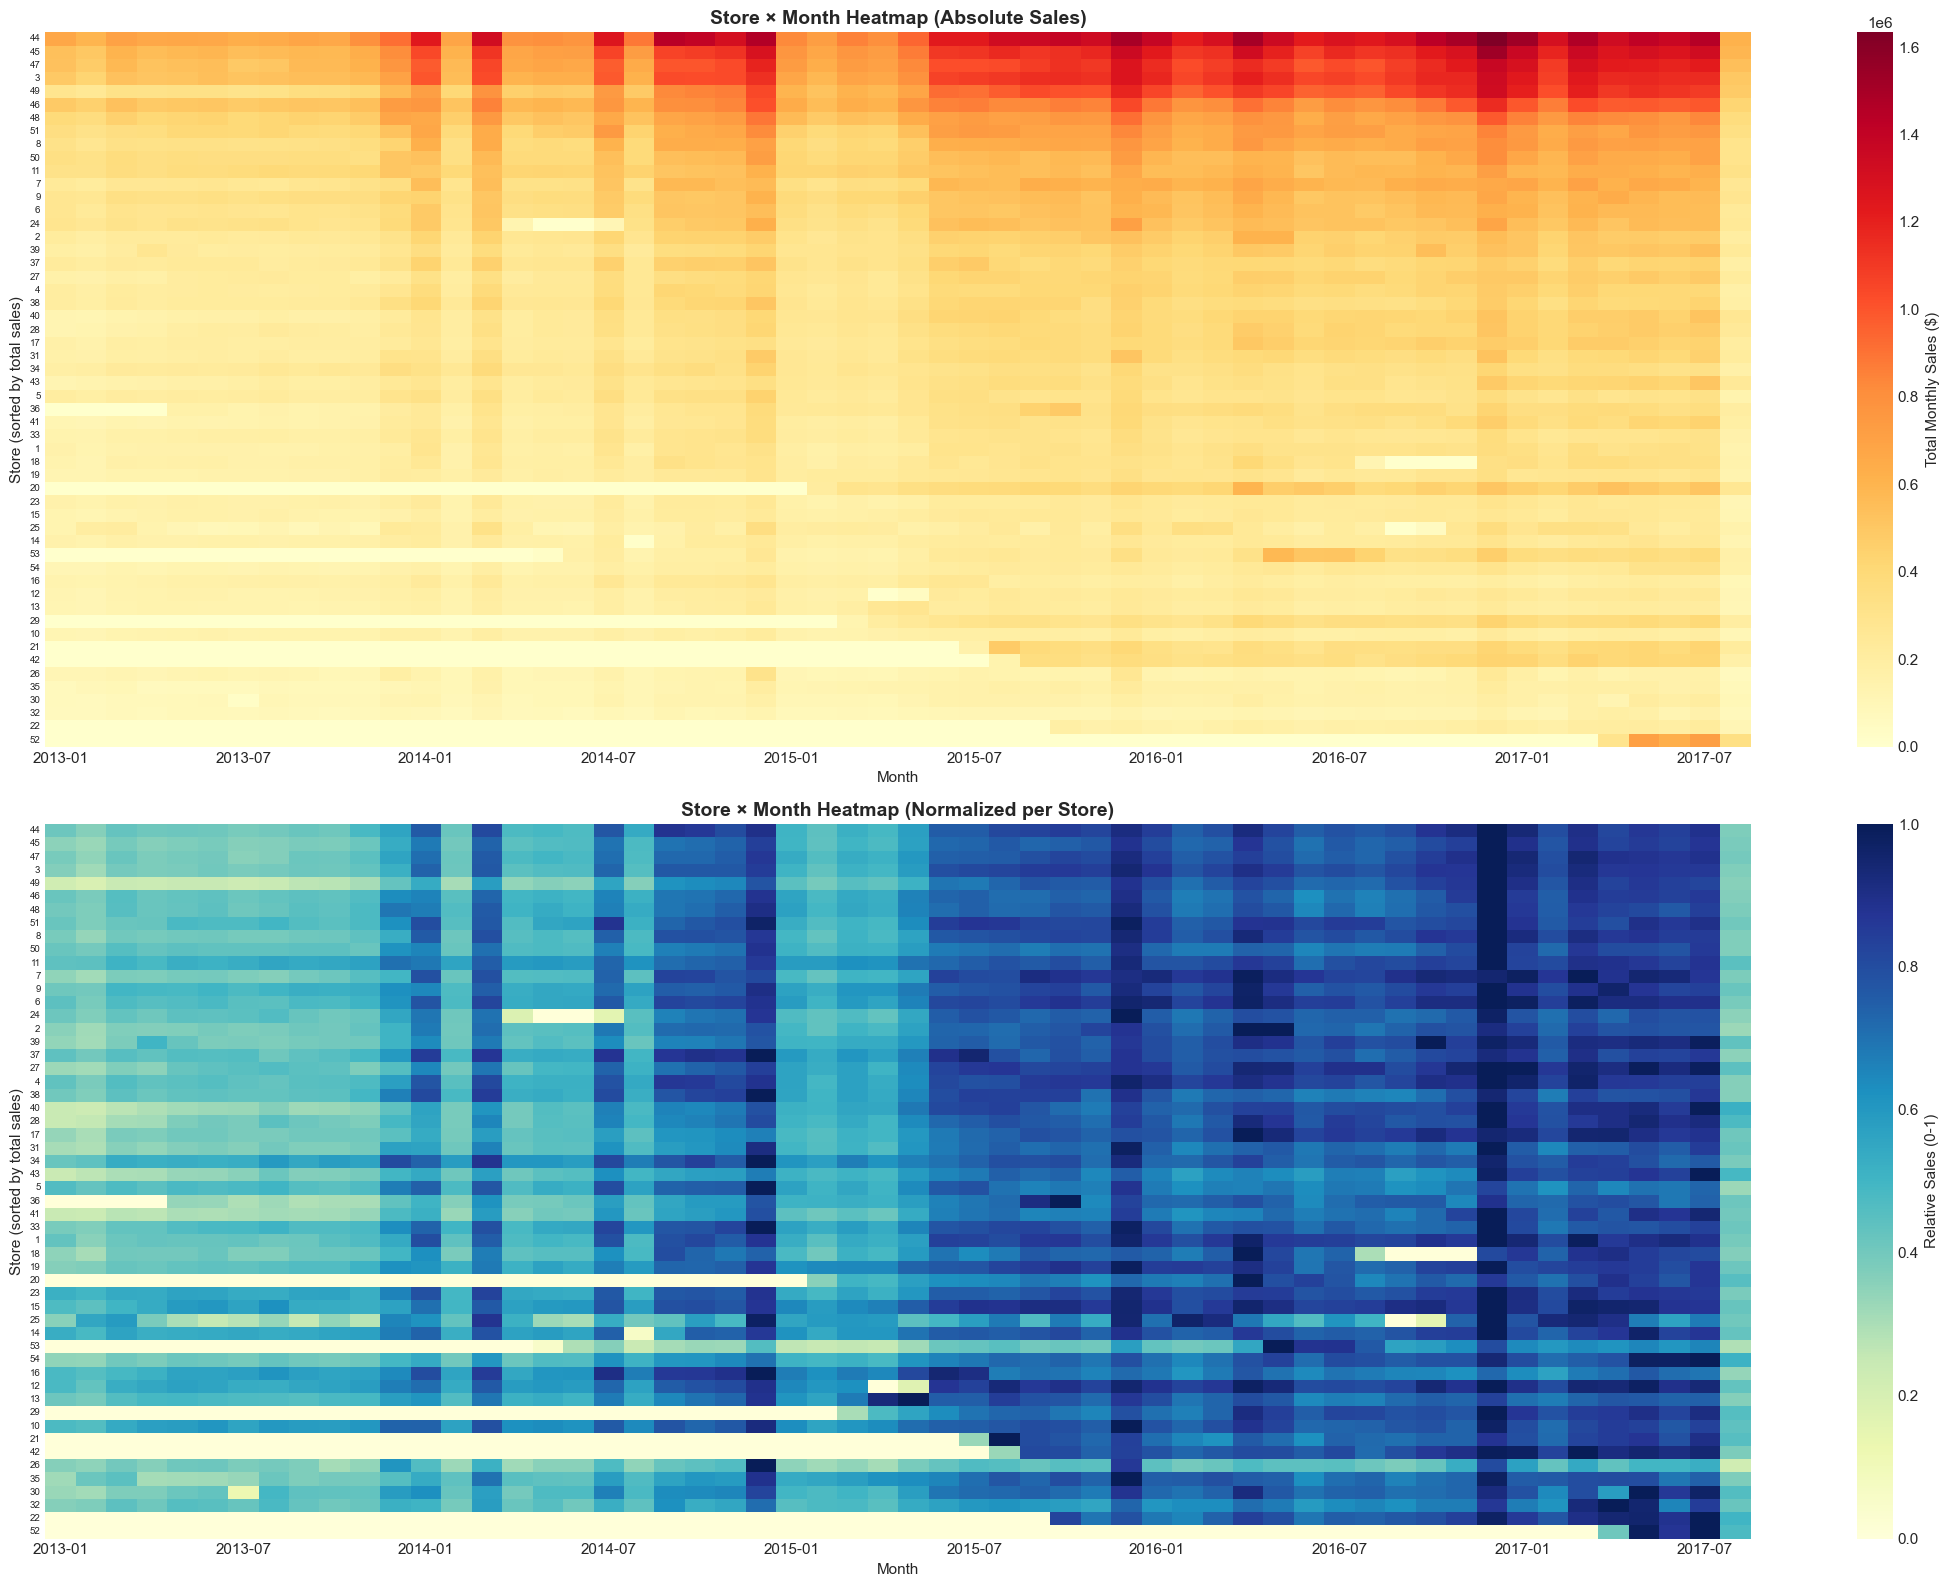

In [60]:
# ==== STORE × MONTH HEATMAP ====
# Aggregate sales by store and month
df['year_month'] = df['date'].dt.to_period('M')
store_monthly = df.groupby(['store_nbr', 'year_month'])['sales'].sum().reset_index()
store_monthly['year_month_str'] = store_monthly['year_month'].astype(str)

# Pivot for heatmap
pivot_store_time = store_monthly.pivot_table(
    index='store_nbr', columns='year_month', values='sales', aggfunc='sum'
)

# Sort stores by total sales
store_order = store_metrics.sort_values('total_sales', ascending=False)['store_nbr'].values
pivot_store_time = pivot_store_time.reindex(store_order)

# Normalize each store by its own max (to see relative patterns)
pivot_normalized = pivot_store_time.div(pivot_store_time.max(axis=1), axis=0)

fig, axes = plt.subplots(2, 1, figsize=(22, 16))

# (A) Absolute heatmap
sns.heatmap(pivot_store_time, cmap='YlOrRd', ax=axes[0],
            xticklabels=6, yticklabels=True, cbar_kws={'label': 'Total Monthly Sales ($)'})
axes[0].set_title('Store × Month Heatmap (Absolute Sales)', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Store (sorted by total sales)')
axes[0].tick_params(axis='y', labelsize=7)

# (B) Normalized heatmap (each store relative to its own max)
sns.heatmap(pivot_normalized, cmap='YlGnBu', ax=axes[1],
            xticklabels=6, yticklabels=True, cbar_kws={'label': 'Relative Sales (0-1)'})
axes[1].set_title('Store × Month Heatmap (Normalized per Store)', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Store (sorted by total sales)')
axes[1].tick_params(axis='y', labelsize=7)

plt.tight_layout()
plt.show()

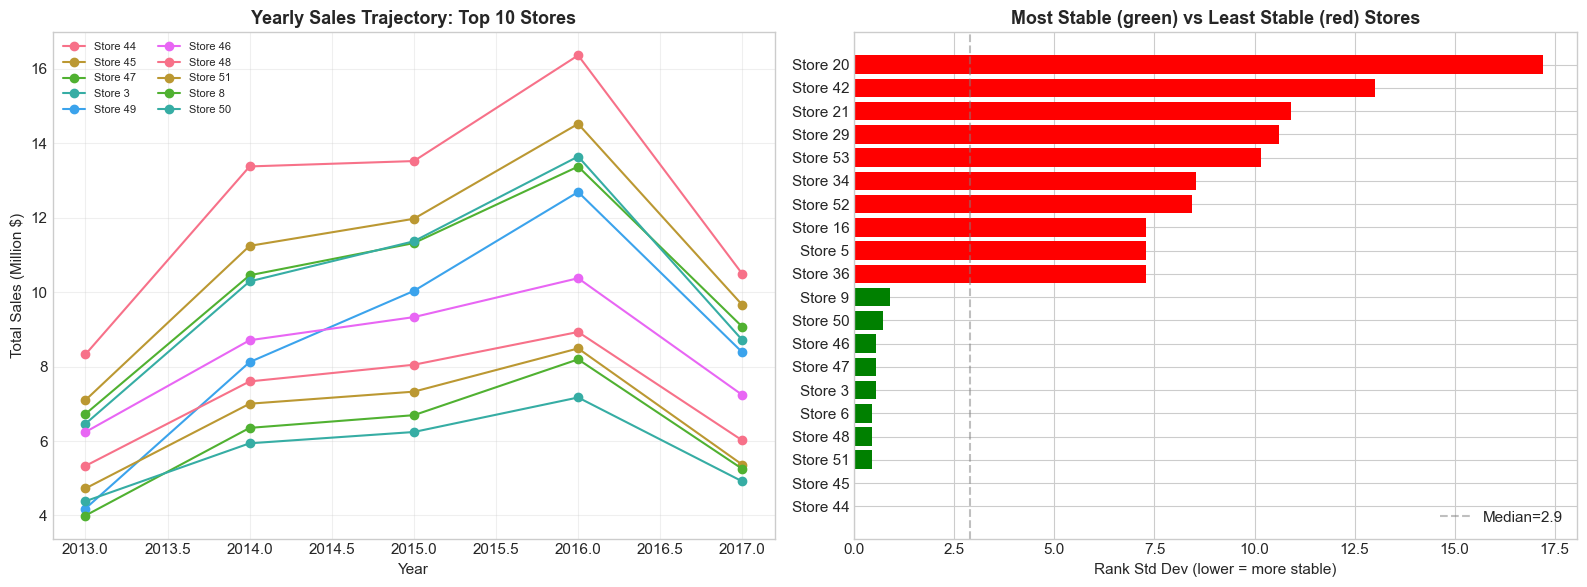


=== Most Stable Stores (consistent rank over years) ===
  Store 44: Quito, Type A, Cluster 5, Rank StdDev=0.00
  Store 45: Quito, Type A, Cluster 11, Rank StdDev=0.00
  Store 51: Guayaquil, Type A, Cluster 17, Rank StdDev=0.45
  Store 48: Quito, Type A, Cluster 14, Rank StdDev=0.45
  Store 6: Quito, Type D, Cluster 13, Rank StdDev=0.45

=== Least Stable Stores (fluctuating rank) ===
  Store 53: Manta, Type D, Cluster 13, Rank StdDev=10.16
  Store 29: Guayaquil, Type E, Cluster 10, Rank StdDev=10.61
  Store 21: Santo Domingo, Type B, Cluster 6, Rank StdDev=10.92
  Store 42: Cuenca, Type D, Cluster 2, Rank StdDev=13.01
  Store 20: Quito, Type B, Cluster 6, Rank StdDev=17.20


In [61]:
# ==== STORE PERFORMANCE CONSISTENCY OVER YEARS ====
df['year'] = df['date'].dt.year
store_yearly = df.groupby(['store_nbr', 'year'])['sales'].sum().reset_index()
pivot_yearly = store_yearly.pivot_table(index='store_nbr', columns='year', values='sales')

# Calculate year-over-year rank stability
yearly_ranks = pivot_yearly.rank(ascending=False)
rank_std = yearly_ranks.std(axis=1).sort_values()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# (A) Line chart: Top 10 stores yearly trajectory
top10_stores = store_metrics.head(10)['store_nbr'].values
for s in top10_stores:
    if s in pivot_yearly.index:
        axes[0].plot(pivot_yearly.columns, pivot_yearly.loc[s] / 1e6, marker='o', label=f'Store {int(s)}')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Total Sales (Million $)')
axes[0].set_title('Yearly Sales Trajectory: Top 10 Stores', fontweight='bold')
axes[0].legend(fontsize=8, ncol=2)
axes[0].grid(True, alpha=0.3)

# (B) Rank stability
most_stable = rank_std.head(10)
least_stable = rank_std.tail(10)
stability = pd.concat([most_stable, least_stable])
colors_stab = ['green'] * 10 + ['red'] * 10
axes[1].barh(
    [f"Store {int(s)}" for s in stability.index],
    stability.values,
    color=colors_stab
)
axes[1].set_xlabel('Rank Std Dev (lower = more stable)')
axes[1].set_title('Most Stable (green) vs Least Stable (red) Stores', fontweight='bold')
axes[1].axvline(x=rank_std.median(), color='gray', linestyle='--', alpha=0.5, label=f'Median={rank_std.median():.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n=== Most Stable Stores (consistent rank over years) ===")
for s in most_stable.index[:5]:
    m = store_metrics[store_metrics['store_nbr'] == s].iloc[0]
    print(f"  Store {int(s)}: {m['city']}, Type {m['type']}, Cluster {int(m['cluster'])}, Rank StdDev={most_stable[s]:.2f}")

print("\n=== Least Stable Stores (fluctuating rank) ===")
for s in least_stable.index[-5:]:
    m = store_metrics[store_metrics['store_nbr'] == s].iloc[0]
    print(f"  Store {int(s)}: {m['city']}, Type {m['type']}, Cluster {int(m['cluster'])}, Rank StdDev={least_stable[s]:.2f}")

## 8. Store Characteristics vs Sales (Scatter Plots)

Tìm patterns giữa các đặc tính của store và sales performance.

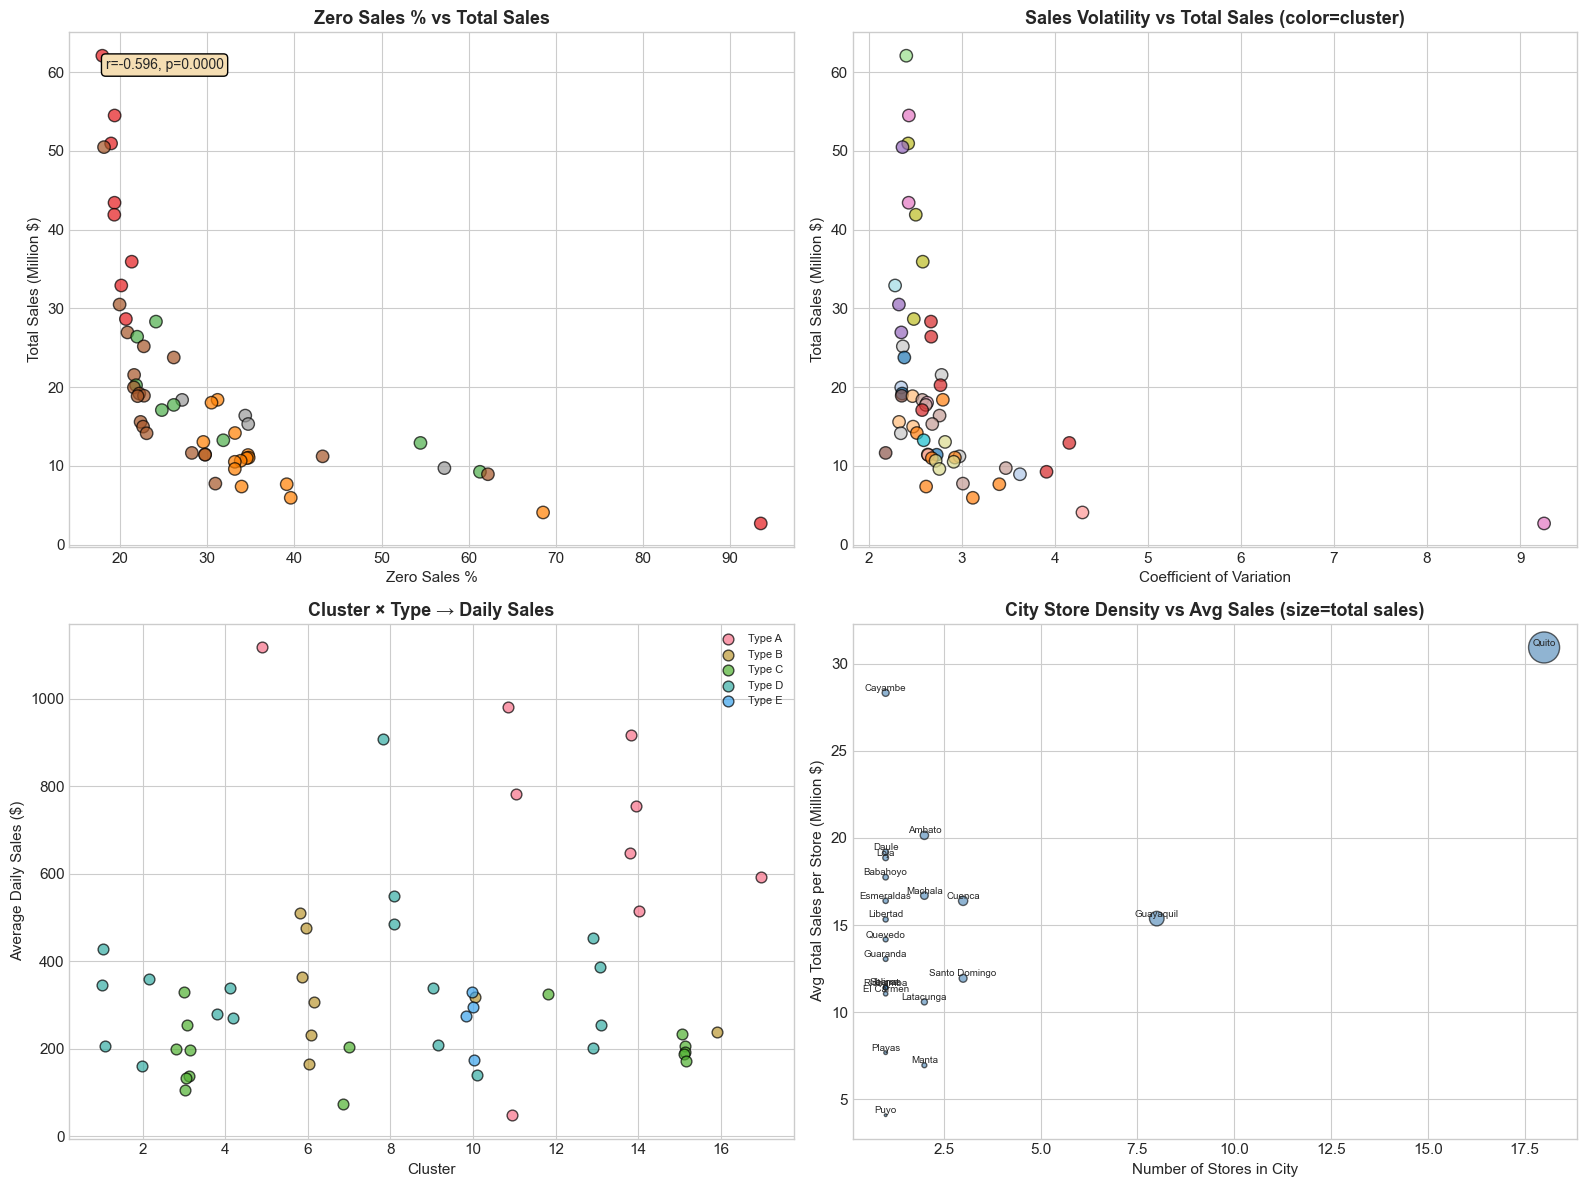

In [62]:
# ==== SCATTER PLOTS: STORE CHARACTERISTICS vs SALES ====
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# (A) Zero sales % vs Total sales
axes[0, 0].scatter(store_metrics['zero_sales_pct'], store_metrics['total_sales'] / 1e6,
                   c=store_metrics['type'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}),
                   cmap='Set1', s=80, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Zero Sales %')
axes[0, 0].set_ylabel('Total Sales (Million $)')
axes[0, 0].set_title('Zero Sales % vs Total Sales', fontweight='bold')
# Add correlation
r, p = stats.pearsonr(store_metrics['zero_sales_pct'], store_metrics['total_sales'])
axes[0, 0].text(0.05, 0.95, f'r={r:.3f}, p={p:.4f}', transform=axes[0, 0].transAxes,
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

# (B) CV vs Total sales
axes[0, 1].scatter(store_metrics['cv'], store_metrics['total_sales'] / 1e6,
                   c=store_metrics['cluster'], cmap='tab20', s=80, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Coefficient of Variation')
axes[0, 1].set_ylabel('Total Sales (Million $)')
axes[0, 1].set_title('Sales Volatility vs Total Sales (color=cluster)', fontweight='bold')

# (C) Cluster vs Average daily sales (jitter plot)
for t in sorted(store_metrics['type'].unique()):
    mask = store_metrics['type'] == t
    axes[1, 0].scatter(store_metrics[mask]['cluster'] + np.random.uniform(-0.2, 0.2, mask.sum()),
                       store_metrics[mask]['avg_daily_sales'],
                       label=f'Type {t}', s=60, alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Average Daily Sales ($)')
axes[1, 0].set_title('Cluster × Type → Daily Sales', fontweight='bold')
axes[1, 0].legend(fontsize=8)

# (D) Number of stores in city vs avg sales
city_plot = city_metrics.copy()
axes[1, 1].scatter(city_plot['num_stores'], city_plot['avg_total_sales'] / 1e6,
                   s=city_plot['total_sales'] / city_plot['total_sales'].max() * 500,
                   alpha=0.6, edgecolor='black', c='steelblue')
for _, row in city_plot.iterrows():
    axes[1, 1].annotate(row['city'], (row['num_stores'], row['avg_total_sales'] / 1e6),
                        fontsize=7, ha='center', va='bottom')
axes[1, 1].set_xlabel('Number of Stores in City')
axes[1, 1].set_ylabel('Avg Total Sales per Store (Million $)')
axes[1, 1].set_title('City Store Density vs Avg Sales (size=total sales)', fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Outlier & Zero-Sales Deep Dive

Nhận diện stores có unusual patterns - quá nhiều zero sales hoặc sales volatility bất thường.

Outlier stores detected: 8

Outlier details:
 store_nbr          city                          state type  cluster  total_sales  avg_daily_sales       cv  zero_sales_pct
        44         Quito                      Pichincha    A        5 6.208755e+07      1117.245254 2.403485       17.947887
        45         Quito                      Pichincha    A       11 5.449801e+07       980.673908 2.431309       19.358670
        47         Quito                      Pichincha    A       14 5.094831e+07       916.798209 2.423998       18.953790
         3         Quito                      Pichincha    D        8 5.048191e+07       908.405495 2.362585       18.140430
        21 Santo Domingo Santo Domingo de los Tsachilas    B        6 9.255506e+06       166.549808 3.910457       61.300655
        42        Cuenca                          Azuay    D        2 8.945768e+06       160.976173 3.624873       62.216584
        22          Puyo                        Pastaza    C        7 4.090202e+

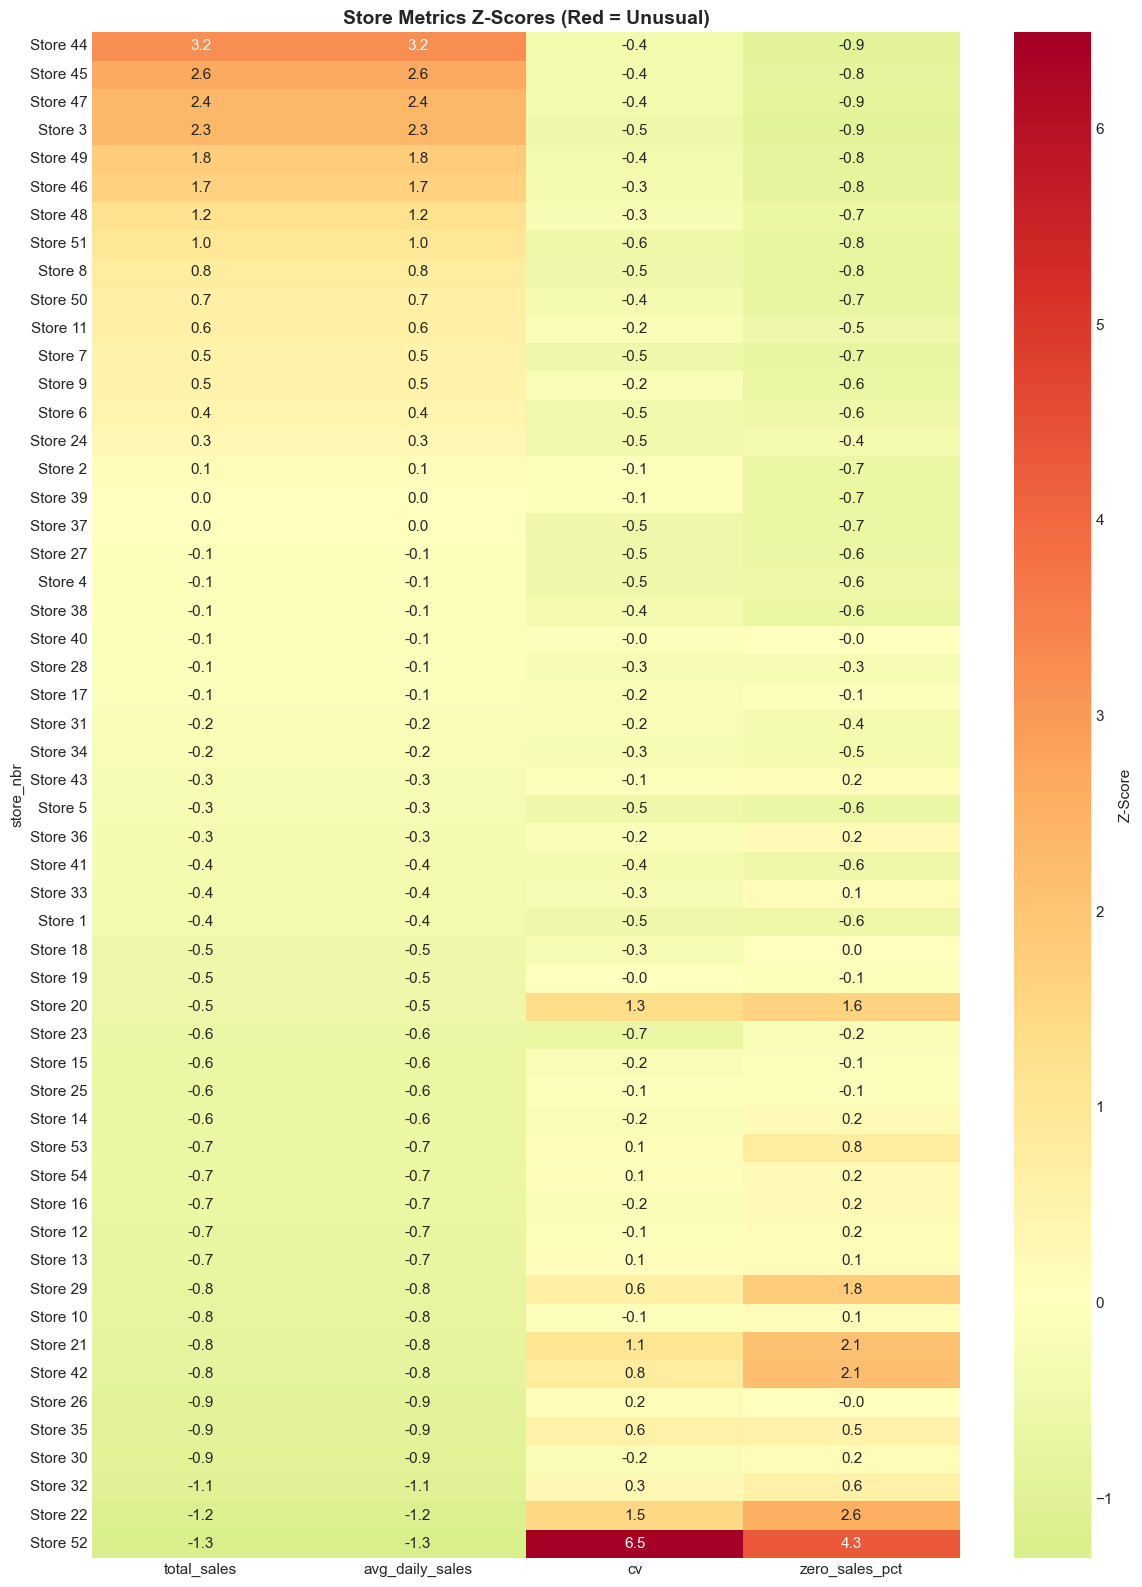

In [63]:
# ==== OUTLIER DETECTION ====
# Z-score based outlier detection on store-level metrics
from scipy.stats import zscore

metrics_for_outlier = ['total_sales', 'avg_daily_sales', 'cv', 'zero_sales_pct']
z_scores = store_metrics[metrics_for_outlier].apply(zscore)
z_scores.index = store_metrics['store_nbr']

# Flag stores with |z| > 2 on any metric
outlier_mask = (z_scores.abs() > 2).any(axis=1)
outlier_stores = store_metrics[store_metrics['store_nbr'].isin(z_scores[outlier_mask].index)]

print(f"Outlier stores detected: {len(outlier_stores)}")
if len(outlier_stores) > 0:
    print("\nOutlier details:")
    print(outlier_stores[['store_nbr', 'city', 'state', 'type', 'cluster',
                          'total_sales', 'avg_daily_sales', 'cv', 'zero_sales_pct']].to_string(index=False))

# Z-score heatmap for all stores
fig, ax = plt.subplots(figsize=(12, 16))
z_display = z_scores.reindex(store_metrics.sort_values('total_sales', ascending=False)['store_nbr'])
sns.heatmap(z_display, annot=True, fmt='.1f', cmap='RdYlGn_r', center=0, ax=ax,
            yticklabels=[f"Store {int(s)}" for s in z_display.index],
            cbar_kws={'label': 'Z-Score'})
ax.set_title('Store Metrics Z-Scores (Red = Unusual)', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

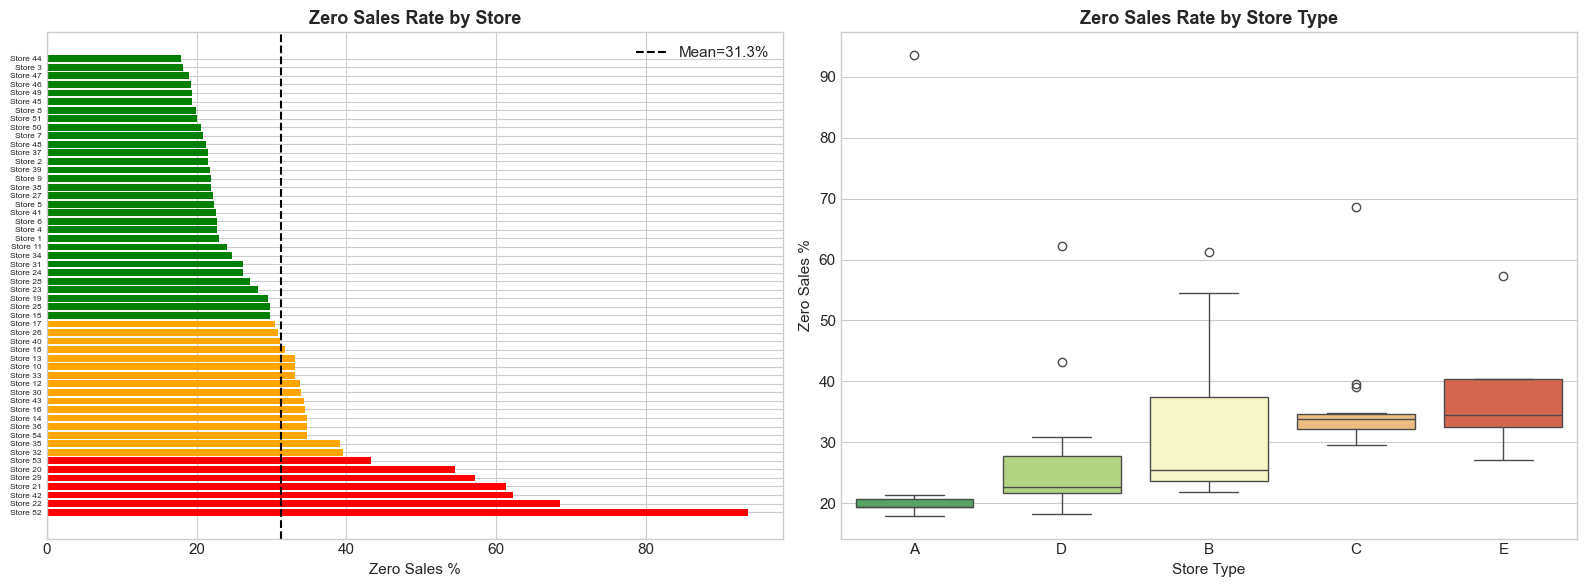

=== Stores with Highest Zero-Sales Rates ===
  Store 52: 93.5% zero sales (Manta, Type A, Cluster 11)
  Store 22: 68.5% zero sales (Puyo, Type C, Cluster 7)
  Store 42: 62.2% zero sales (Cuenca, Type D, Cluster 2)
  Store 21: 61.3% zero sales (Santo Domingo, Type B, Cluster 6)
  Store 29: 57.2% zero sales (Guayaquil, Type E, Cluster 10)


In [64]:
# ==== ZERO SALES DEEP DIVE ====
# Which stores have unusually high zero-sales rates?
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# (A) Zero sales % by store (sorted)
zero_sorted = store_metrics.sort_values('zero_sales_pct', ascending=False)
colors_zero = ['red' if z > 40 else 'orange' if z > 30 else 'green'
               for z in zero_sorted['zero_sales_pct']]
axes[0].barh(
    [f"Store {int(s)}" for s in zero_sorted['store_nbr']],
    zero_sorted['zero_sales_pct'],
    color=colors_zero
)
axes[0].set_xlabel('Zero Sales %')
axes[0].set_title('Zero Sales Rate by Store', fontweight='bold')
axes[0].axvline(x=store_metrics['zero_sales_pct'].mean(), color='black', linestyle='--',
                label=f"Mean={store_metrics['zero_sales_pct'].mean():.1f}%")
axes[0].legend()
axes[0].tick_params(axis='y', labelsize=6)

# (B) Zero sales % by store type
sns.boxplot(data=store_metrics, x='type', y='zero_sales_pct', ax=axes[1], palette='RdYlGn_r')
axes[1].set_title('Zero Sales Rate by Store Type', fontweight='bold')
axes[1].set_ylabel('Zero Sales %')
axes[1].set_xlabel('Store Type')

plt.tight_layout()
plt.show()

# Print stores with highest zero-sales rates
print("=== Stores with Highest Zero-Sales Rates ===")
high_zero = store_metrics.nlargest(5, 'zero_sales_pct')
for _, row in high_zero.iterrows():
    print(f"  Store {int(row['store_nbr'])}: {row['zero_sales_pct']:.1f}% zero sales "
          f"({row['city']}, Type {row['type']}, Cluster {int(row['cluster'])})")

## 10. Product Family Performance by Store Type

Phân tích xem các store types khác nhau có bán các product families khác nhau không.

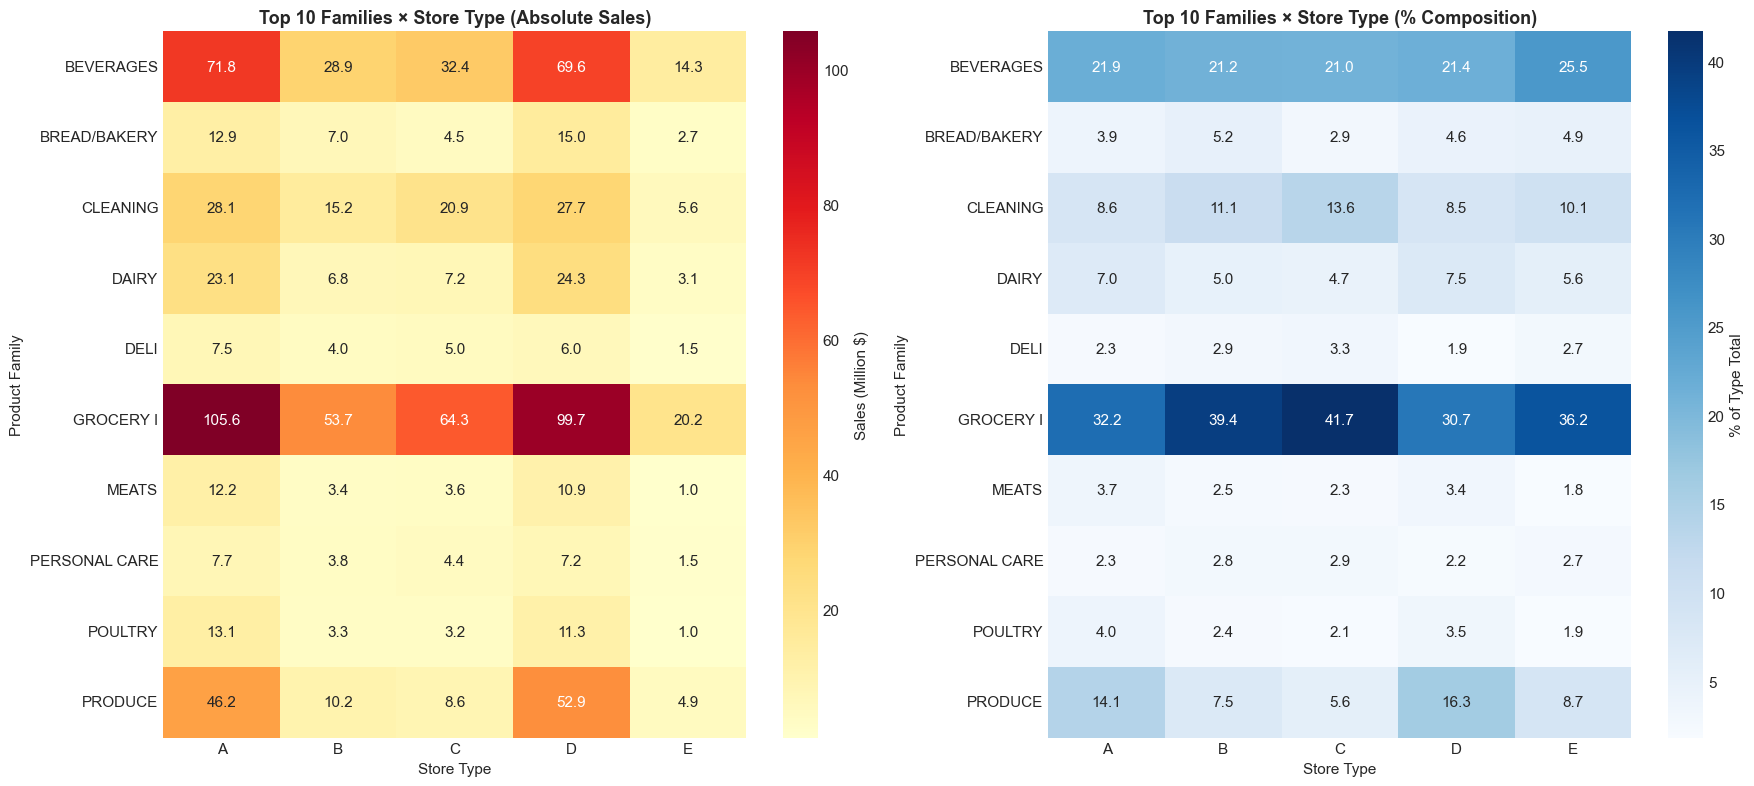

In [65]:
# ==== PRODUCT FAMILY × STORE TYPE ====
family_type = df.groupby(['type', 'family'])['sales'].sum().reset_index()
top_families = df.groupby('family')['sales'].sum().nlargest(10).index

# Filter top families for clarity
family_type_top = family_type[family_type['family'].isin(top_families)]
pivot_ft = family_type_top.pivot_table(index='family', columns='type', values='sales', aggfunc='sum')

# Normalize by type total to see % composition
pivot_ft_pct = pivot_ft.div(pivot_ft.sum(axis=0), axis=1) * 100

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# (A) Absolute sales heatmap
sns.heatmap(pivot_ft / 1e6, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[0],
            cbar_kws={'label': 'Sales (Million $)'})
axes[0].set_title('Top 10 Families × Store Type (Absolute Sales)', fontweight='bold')
axes[0].set_ylabel('Product Family')
axes[0].set_xlabel('Store Type')

# (B) Percentage composition heatmap
sns.heatmap(pivot_ft_pct, annot=True, fmt='.1f', cmap='Blues', ax=axes[1],
            cbar_kws={'label': '% of Type Total'})
axes[1].set_title('Top 10 Families × Store Type (% Composition)', fontweight='bold')
axes[1].set_ylabel('Product Family')
axes[1].set_xlabel('Store Type')

plt.tight_layout()
plt.show()

## 11. Store Predictability Score

Đánh giá stores nào dễ predict hơn dựa trên variance, zero-sales, và consistency.

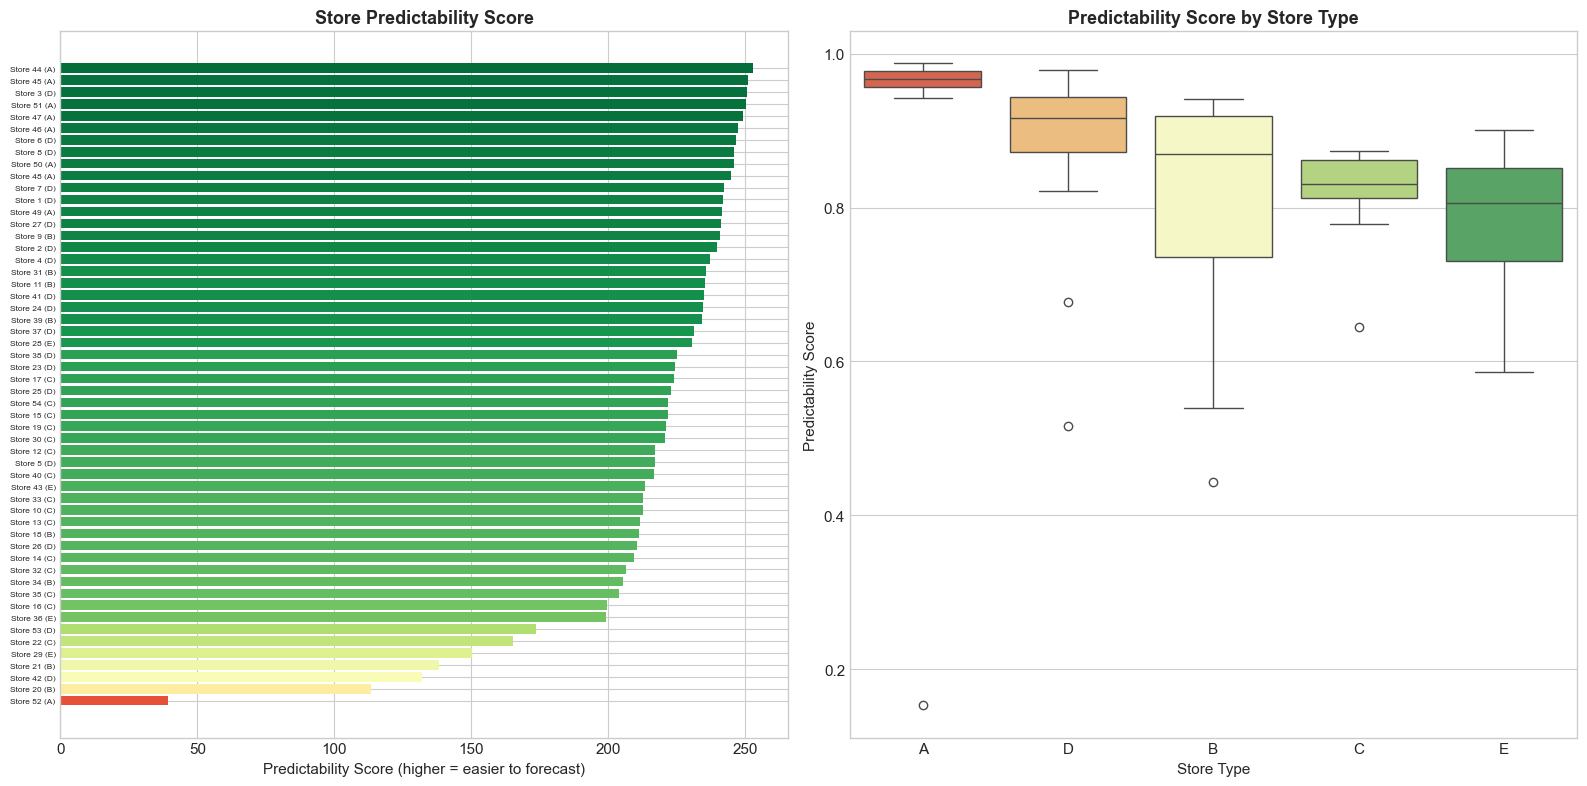

=== Most Predictable Stores ===
  Store 44: Score=0.987 (Quito, Type A, CV=2.40)
  Store 45: Score=0.980 (Quito, Type A, CV=2.43)
  Store 3: Score=0.979 (Quito, Type D, CV=2.36)
  Store 51: Score=0.978 (Guayaquil, Type A, CV=2.28)
  Store 47: Score=0.973 (Quito, Type A, CV=2.42)

=== Least Predictable Stores ===
  Store 52: Score=0.153 (Manta, Type A, CV=9.26)
  Store 20: Score=0.443 (Quito, Type B, CV=4.16)
  Store 42: Score=0.516 (Cuenca, Type D, CV=3.62)
  Store 21: Score=0.540 (Santo Domingo, Type B, CV=3.91)
  Store 29: Score=0.586 (Guayaquil, Type E, CV=3.47)


In [66]:
# ==== PREDICTABILITY SCORE ====
# Higher score = easier to predict
# Components: inverse CV, low zero-sales%, rank stability
store_metrics['cv_score'] = 1 - (store_metrics['cv'] - store_metrics['cv'].min()) / (store_metrics['cv'].max() - store_metrics['cv'].min())
store_metrics['zero_score'] = 1 - (store_metrics['zero_sales_pct'] - store_metrics['zero_sales_pct'].min()) / (store_metrics['zero_sales_pct'].max() - store_metrics['zero_sales_pct'].min())

# Add rank stability (from yearly analysis)
rank_std_series = yearly_ranks.std(axis=1)
store_metrics = store_metrics.merge(
    rank_std_series.reset_index().rename(columns={'index': 'store_nbr', 0: 'rank_std'}),
    on='store_nbr', how='left'
)
store_metrics['stability_score'] = 1 - (store_metrics['rank_std'] - store_metrics['rank_std'].min()) / (store_metrics['rank_std'].max() - store_metrics['rank_std'].min())

# Composite score
store_metrics['predictability'] = (
    0.4 * store_metrics['cv_score'] +
    0.3 * store_metrics['zero_score'] +
    0.3 * store_metrics['stability_score']
)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# (A) Predictability score distribution
pred_sorted = store_metrics.sort_values('predictability', ascending=True)
colors_pred = plt.cm.RdYlGn(pred_sorted['predictability'])
axes[0].barh(
    [f"Store {int(s)} ({t})" for s, t in zip(pred_sorted['store_nbr'], pred_sorted['type'])],
    pred_sorted['predictability'],
    color=colors_pred
)
axes[0].set_xlabel('Predictability Score (higher = easier to forecast)')
axes[0].set_title('Store Predictability Score', fontweight='bold')
axes[0].tick_params(axis='y', labelsize=6)

# (B) Predictability by type
sns.boxplot(data=store_metrics, x='type', y='predictability', ax=axes[1], palette='RdYlGn')
axes[1].set_title('Predictability Score by Store Type', fontweight='bold')
axes[1].set_ylabel('Predictability Score')
axes[1].set_xlabel('Store Type')

plt.tight_layout()
plt.show()

# Print results
print("=== Most Predictable Stores ===")
for _, row in store_metrics.nlargest(5, 'predictability').iterrows():
    print(f"  Store {int(row['store_nbr'])}: Score={row['predictability']:.3f} "
          f"({row['city']}, Type {row['type']}, CV={row['cv']:.2f})")

print("\n=== Least Predictable Stores ===")
for _, row in store_metrics.nsmallest(5, 'predictability').iterrows():
    print(f"  Store {int(row['store_nbr'])}: Score={row['predictability']:.3f} "
          f"({row['city']}, Type {row['type']}, CV={row['cv']:.2f})")

## 12. Modeling Recommendations

Dựa trên kết quả phân tích, đưa ra recommendations cho strategy modeling.

In [67]:
# ==== MODELING STRATEGY ANALYSIS ====
print("="*70)
print("MODELING RECOMMENDATIONS")
print("="*70)

# 1. Should we model by store type?
print("\n1. MODEL BY STORE TYPE?")
type_cv_mean = store_metrics.groupby('type')['cv'].mean()
type_sales_mean = store_metrics.groupby('type')['avg_daily_sales'].mean()
print(f"   Type-level CV (lower = more predictable):")
for t in sorted(type_cv_mean.index):
    print(f"     Type {t}: CV={type_cv_mean[t]:.3f}, Avg Daily=${type_sales_mean[t]:,.0f}")

# 2. Should we model by cluster?
print("\n2. MODEL BY CLUSTER?")
within_cluster_cv = store_metrics.groupby('cluster')['total_sales'].apply(
    lambda x: x.std() / x.mean() if x.mean() > 0 else np.inf
)
print(f"   Within-cluster CV (lower = more homogeneous):")
print(f"   Mean: {within_cluster_cv.mean():.3f}")
print(f"   Range: {within_cluster_cv.min():.3f} - {within_cluster_cv.max():.3f}")
print(f"   => Clusters {'ARE' if within_cluster_cv.mean() < 0.5 else 'MAY NOT BE'} good grouping variables")

# 3. Region-based modeling
print("\n3. MODEL BY REGION?")
region_cv = store_metrics.groupby('region')['total_sales'].apply(
    lambda x: x.std() / x.mean() if x.mean() > 0 else np.inf
)
for r in region_cv.index:
    n = (store_metrics['region'] == r).sum()
    print(f"   {r}: within-group CV={region_cv[r]:.3f} (n={n})")

# 4. Individual store models
print("\n4. INDIVIDUAL STORE MODELS?")
high_sales_stores = store_metrics[store_metrics['total_sales'] > store_metrics['total_sales'].quantile(0.75)]
print(f"   High-volume stores (top 25%): {len(high_sales_stores)} stores")
print(f"   These may benefit from individual models due to unique patterns")
print(f"   Stores: {sorted(high_sales_stores['store_nbr'].values)}")

# 5. Summary table
print("\n5. STRATEGY SUMMARY:")
print("   ┌────────────────────────────┬─────────────────────────────────┐")
print("   │ Approach                   │ Recommendation                  │")
print("   ├────────────────────────────┼─────────────────────────────────┤")
print("   │ Global model (all stores)  │ Baseline, but loses nuance      │")
print("   │ Model per store type       │ Good if type differences signif │")
print("   │ Model per cluster          │ Depends on cluster homogeneity  │")
print("   │ Model per store            │ Best for top stores, expensive  │")
print("   │ Hierarchical model         │ Best balance of accuracy/cost   │")
print("   └────────────────────────────┴─────────────────────────────────┘")

MODELING RECOMMENDATIONS

1. MODEL BY STORE TYPE?
   Type-level CV (lower = more predictable):
     Type A: CV=3.200, Avg Daily=$706
     Type B: CV=2.994, Avg Daily=$327
     Type C: CV=2.898, Avg Daily=$197
     Type D: CV=2.543, Avg Daily=$351
     Type E: CV=2.873, Avg Daily=$269

2. MODEL BY CLUSTER?
   Within-cluster CV (lower = more homogeneous):
   Mean: 0.385
   Range: 0.117 - 0.813
   => Clusters ARE good grouping variables

3. MODEL BY REGION?
   Coastal: within-group CV=0.488 (n=20)
   Highland: within-group CV=0.623 (n=33)
   Other: within-group CV=nan (n=1)

4. INDIVIDUAL STORE MODELS?
   High-volume stores (top 25%): 14 stores
   These may benefit from individual models due to unique patterns
   Stores: [np.int64(3), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(11), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51)]

5. STRATEGY SUMMARY:
   ┌────────────────────────────┬─────────────────────────